# Import libraries and set configs

In [1]:
import sys
sys.path.append('..')

import os
import json
import joblib
import random
import warnings
from collections import defaultdict
import numpy as np
import pandas as pd
from glob import glob
from optimizer.optimizer import Optimizer
from os import environ
from datetime import timedelta
from tqdm.auto import tqdm
from datetime import datetime

from eli5.sklearn import PermutationImportance

import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

from colorama import Style, Fore

# Set environment variable
environ["ENV"] = "optimize"

from config.config import ConfigFactory
from indicators import indicators

from api.tvdatafeed.main import TvDatafeed, Interval
from constants.constants import tv_username, tv_password


class CFG:
    load = False
    historical = False
    create_dataset = False
    cls_target_ratio_tp = 1.03
    cls_target_ratio_sl = 1.03
    ttype = 'both'
    patterns_to_filter = ['STOCH_RSI_Volume24']
    select_features = False
    optimize = False
    n_repeats = 1
    n_folds = 8
    agg_periods = [24, 168, 720]
    agg_funcs = [np.min, np.max, np.mean, np.median, np.std]

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

tqdm.pandas()

warnings.simplefilter(action='ignore', category=(FutureWarning, pd.errors.PerformanceWarning))

# Load data

### Load STOCH_RSI buy data

In [2]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'buy'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=True, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=True, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 31060

### Load STOCH_RSI sell data

In [3]:
work_timeframe = '1h'
higher_timeframe = '4h'
opt_limit = 100000

ttype = 'sell'
pattern = ['STOCH', 'RSI', 'Volume24']
indicator_list = pattern
indicator_list_higher = ['Trend', 'MACD']

# Get configs
configs = ConfigFactory.factory(environ).configs
configs['Indicator_list'] = indicator_list
configs['Higher_TF_indicator_list'] = indicator_list_higher
configs['Timeframes']['work_timeframe'] = work_timeframe
configs['Timeframes']['higher_timeframe'] = higher_timeframe

optim_dict = {
                'RSI': {
                        'timeperiod': [14], 
                        'low_bound': [35]
                       },
                'STOCH': {
                          'fastk_period': [9],
                          'slowk_period': [7],
                          'slowd_period': [3], 
                          'low_bound': [25]
                        }
             }

if CFG.load:
  print(f'Timeframe is {work_timeframe}/{higher_timeframe}, trade type is {ttype}')
  opt = Optimizer(pattern, optim_dict, clean=False, **configs)
  min_time = datetime.now().replace(microsecond=0, second=0, minute=0) - pd.to_timedelta(365 * 10, unit='D')
  stat = opt.optimize(pattern, ttype, opt_limit, load=False, op_type='ml', historical=CFG.historical, min_time=min_time)
  display(stat) # 23629

# Test loaded data

### Remove dataframe files with the biggest number of missing data

In [4]:
counter = 0 

tickers_1h = glob('../optimizer/ticker_dataframes/*_1h.pkl')
for ticker in tqdm(tickers_1h[3:]):
    df = pd.read_pickle(ticker)
    nunique = df['time'].diff()[1:].nunique()
    if nunique > 1:
        count = df[df['time'].diff().astype('timedelta64[h]') != 1].shape[0]
        if count > 200:
            print(ticker, nunique, count)
            os.remove(ticker)
            os.remove(ticker[:-6] + '4h.pkl')
            
counter

  0%|          | 0/2495 [00:00<?, ?it/s]

0

### Plot time vs index for some of dataframe files

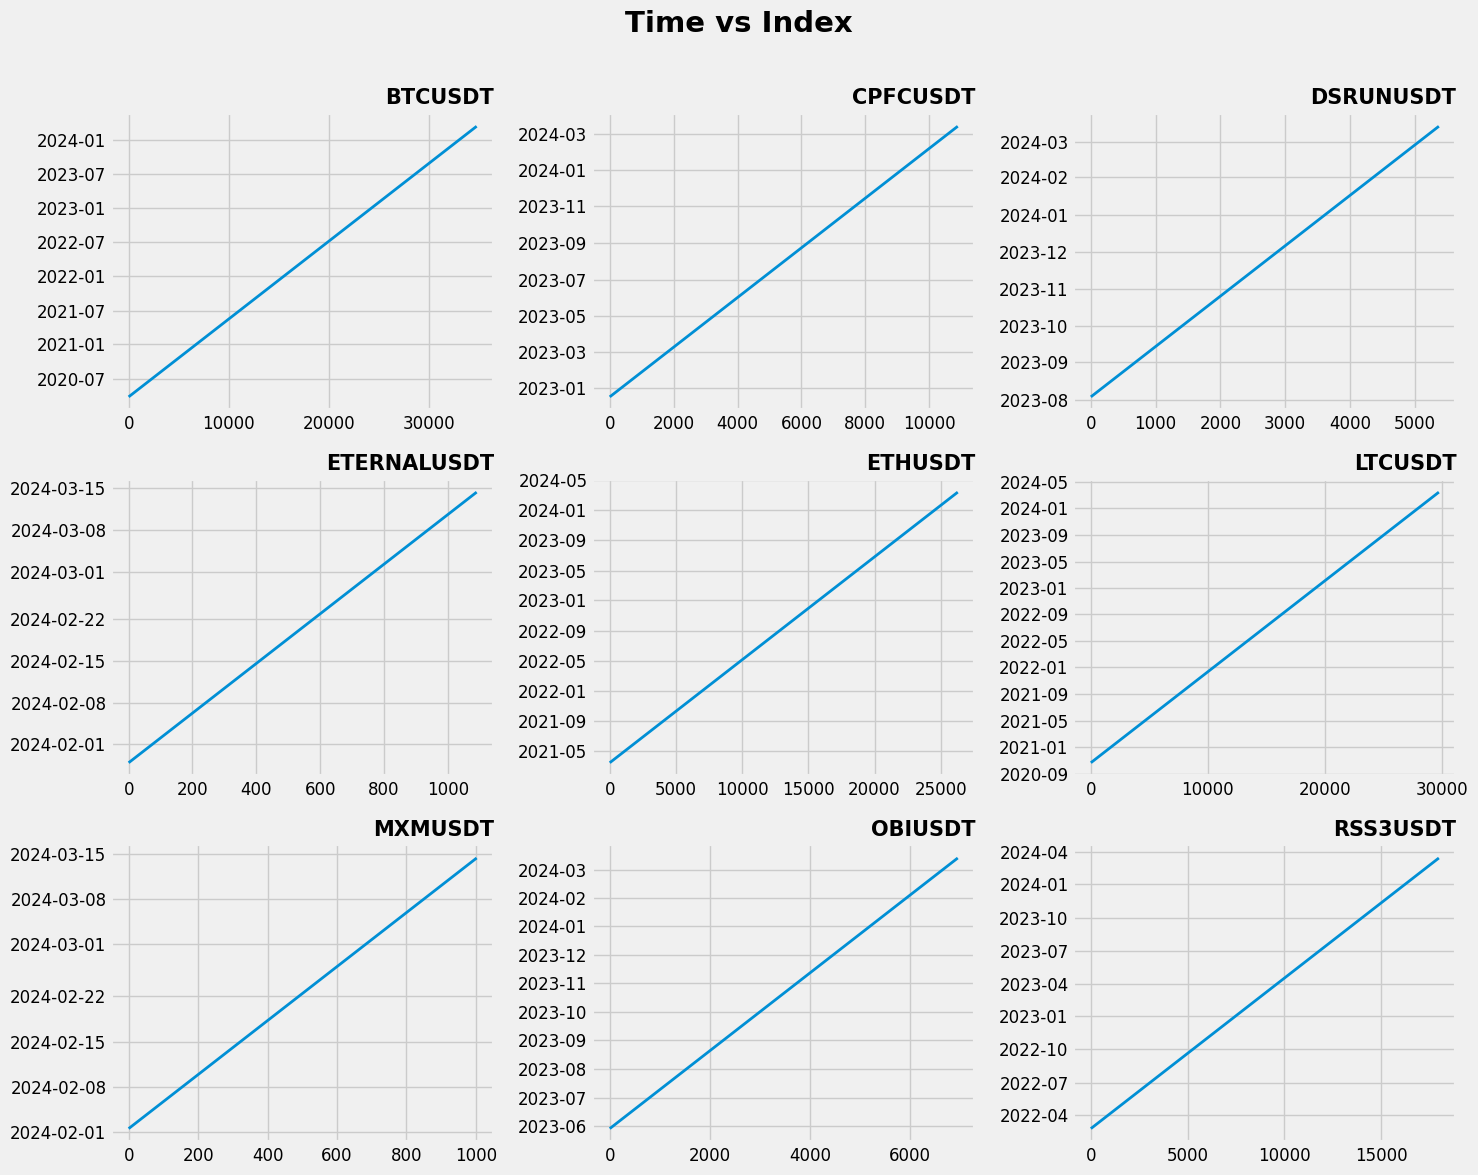

In [5]:
%matplotlib inline

n_cols = 3
n_rows = 3
figsize = (15, 4 * n_rows)

tickers = glob('../optimizer/ticker_dataframes/*_1h.pkl')
random_tickers = random.choices(tickers, k=n_cols*n_rows)
random_tickers[:3] = [t for t in tickers if '/BTCUSDT_1h' in t or '/ETHUSDT_1h' in t or '/LTCUSDT_1h' in t]

def plot_times(random_tickers, n_rows, n_cols):
    fig = plt.figure(figsize=figsize)
    
    for idx in range(n_cols*n_rows):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        
        df = pd.read_pickle(random_tickers[idx])
        sns.lineplot(data=df['time'])

        ax.set_ylabel('')
        plt.yticks(fontsize=12) 
        ax.set_xlabel('')
        plt.xticks(fontsize=12)
        # ax.spines['right'].set_visible(False)
        ax.set_title(f'{random_tickers[idx].split("/")[-1][:-7]}', loc='right', weight='bold', fontsize=15)
        ax.lines[0].set_linewidth(2)

    
    fig.suptitle(f'Time vs Index\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
plot_times(sorted(random_tickers),  n_rows=n_rows, n_cols=n_cols) 

### Check if all dataframe files has data for both timeframes 1h and 4h

In [6]:
import glob

x = glob.glob('../optimizer/ticker_dataframes/*.pkl')
y = [i[31:].split('_')[0] for i in x]
z = ('').join(x)

for i in y:
    if f'{i}_1h' not in z:
        print(i, '1h')
    if f'{i}_4h' not in z:
        print(i, '4h')

# Prepare and create train data

### Functions

In [7]:
# Get configs
configs = ConfigFactory.factory(environ).configs

higher_features = ['time', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist', 'macdsignal']
price_cols = ['open','high', 'low', 'close']
real_price_cols = ['real_high', 'real_low', 'real_close']
funding_cols = ['funding_rate']
rsi_stoch_cols = ['rsi', 'stoch_diff', 'stoch_slowd', 'stoch_slowk']
btcd_cols = ['time', 'btcd_open', 'btcd_high', 'btcd_low', 'btcd_close', 'btcd_volume']
btcdom_cols = ['time', 'btcdom_open', 'btcdom_high', 'btcdom_low', 'btcdom_close', 'btcdom_volume']

def get_file(ticker):
    ''' Find files buy ticker names '''
    try:
        tmp_df_1h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
        tmp_df_4h = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')
    except FileNotFoundError:
        return None, None
    else:
        return tmp_df_1h, tmp_df_4h

def add_indicators(df, df_higher, ttype, configs):
    # add RSI
    rsi = indicators.RSI(ttype, configs)
    df = rsi.get_indicator(df, '', '', 0)
    # add Stochastic
    stoch = indicators.STOCH(ttype, configs)
    df = stoch.get_indicator(df, '', '', 0)
    # add ATR
    atr = indicators.ATR(ttype, configs)
    df = atr.get_indicator(df, '', '', 0)
    # add CCI
    cci = indicators.CCI(ttype, configs)
    df = cci.get_indicator(df, '', '', 0)
    # add SAR
    sar = indicators.SAR(ttype, configs)
    df = sar.get_indicator(df, '', '', 0)
    # add MACD
    macd = indicators.MACD(ttype, configs)
    df_higher = macd.get_indicator(df_higher, '', '', 0)
    # add Trend
    trend = indicators.Trend(ttype, configs)
    df_higher = trend.get_indicator(df_higher, '', '', 0)
    # merge higher timeframe indicators with working timeframe
    df_higher['time'] = df_higher['time'] + pd.to_timedelta(3, unit='h')
    df[higher_features] = pd.merge(df[['time']], df_higher[higher_features], how='left', on='time')
    df.drop(columns=['close_smooth'], inplace=True)
    df.drop(columns=[c for c in df.columns if c.endswith('_dir')], inplace=True)
    # merge with BTC.D dataframe
    df[btcd_cols] = pd.merge(df[['time']], btcd[btcd_cols], how='left', on='time')
    # merge with BTCDOM dataframe
    df[btcdom_cols] = pd.merge(df[['time']], btcdom[btcdom_cols], how='left', on='time')
    df.ffill(inplace=True)
    df[btcdom_cols] = df[btcdom_cols].fillna(df[btcdom_cols].mean().round(1))
    # price and MACD columns to pct difference
    df[real_price_cols] = df[['high', 'low', 'close']]
    cols_to_scale = ['open', 'high', 'low', 'close', 'macd', 'macdhist', 'macdsignal', 'atr']
    for c in cols_to_scale:
        df[c] = df[c].pct_change() * 100
    return df.reset_index(drop=True)


def create_train_df(df, ttype, configs, target_offset, first, last, step):
    ''' Create train dataset from signal statistics and ticker candle data'''
    train_df = pd.DataFrame()
    tickers = df['ticker'].unique()
    
    for ticker in tqdm(tickers):
        # get signals with current ticker
        signal_df = df[df['ticker'] == ticker]
        times = signal_df['time']
        
        # load candle history of this ticker
        tmp_df_1h, tmp_df_4h = get_file(ticker)

        # add indicators 
        try:
            tmp_df_1h = add_indicators(tmp_df_1h, tmp_df_4h, ttype, configs)
        except TypeError:
            # print(f'TypeError, ticker - {ticker}')
            continue

        # add historical data for current ticker
        for i, t in enumerate(times.to_list()):
            pass_cycle, sl = False, False
            pattern = signal_df.iloc[i, signal_df.columns.get_loc('pattern')]
            row = tmp_df_1h.loc[tmp_df_1h['time'] == t, :].reset_index(drop=True)
            
            for i in range(first, last + 1, step):
                # collect features every 4 hours, save difference between the current feature and the lagged features
                time_prev = t + timedelta(hours= -i)
                try:
                    row_tmp = tmp_df_1h.loc[tmp_df_1h['time'] == time_prev, [c for c in tmp_df_1h.columns if c not in real_price_cols]].reset_index(drop=True)
                    if i % 8 != 0:
                        row_tmp = row_tmp.drop(columns=funding_cols)
                    if i % 24 != 0:
                        row_tmp = row_tmp.drop(columns=btcd_cols)
                    row_tmp.columns = [c + f'_prev_{i}' for c in row_tmp.columns]
                except IndexError:
                    pass_cycle = True
                    break
                row = pd.concat([row, row_tmp.iloc[:,1:]], axis=1)
                row['ticker'] = ticker
                row['pattern'] = pattern
                
            if pass_cycle:
                continue

            row['target'] = 0
            row['ttype'] = ttype
            
            # If ttype = buy and during the selected period high price was higher than close_price * target_ratio
            # and earlier low price wasn't lower than close_price / target_ratio, than target is True, else target is False.
            # Similarly for ttype = sell 
            if pattern.startswith('MACD'):
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t + timedelta(hours=3), 'real_close']
            else:
                close_price = tmp_df_1h.loc[tmp_df_1h['time'] == t, 'real_close']

            # move to the next ticker if can't find any data corresponding to time t
            if close_price.shape[0] == 0:
                break
            
            close_price = close_price.values[0]
            
            for i in range(1, target_offset + 1):
                if pattern.startswith('MACD'):
                    time_next = t + timedelta(hours=3+i)
                else:
                    time_next = t + timedelta(hours=i)
                    
                target_buy = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_high']
                target_sell = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_low']
                
                if target_buy.shape[0] == 0 or target_sell.shape[0] == 0:
                    pass_cycle = True
                    break
                
                target_buy = target_buy.values[0]
                target_sell = target_sell.values[0]

                # set 
                higher_price = close_price * CFG.cls_target_ratio_tp
                lower_price = close_price * (2 - CFG.cls_target_ratio_tp)
                target_buy_tp = 1 if target_buy > higher_price else 0
                target_buy_sl = 1 if target_buy > higher_price else 0
                target_sell_tp = 1 if target_sell < lower_price else 0
                target_sell_sl = 1 if target_sell < lower_price else 0

                pattern = row['pattern'].values[0]
                ttype = row['ttype'].values[0]
                
                # set SL flag and exit cycle if price reaches stop-loss threshold before it reaches take-profit threshold
                # (SL depends on ttype and pattern)
                sl1 = pattern.startswith('STOCH') and ttype == 'buy' and target_buy_sl == 1
                sl2 = pattern.startswith('STOCH') and ttype == 'sell' and target_sell_sl == 1

                # set TP flag and exit cycle if price reaches take-profit threshold and doesn't reach stop-loss threshold before
                # (TP depends on ttype and pattern)
                tp1 = pattern.startswith('STOCH') and ttype == 'buy' and target_sell_tp == 1
                tp2 = pattern.startswith('STOCH') and ttype == 'sell' and target_buy_tp == 1
                    
                # if both TP and SL flag is on - don't consider that trade
                if (tp1 and sl1) or (tp2 and sl2):
                    pass_cycle = True
                    break
                elif sl1 or sl2:
                    break
                elif tp1 or tp2:
                    row['target'] = 1
                    break
                
                # if price doesn't reaches both TP and SL thresholds but price above / below enter price for buy / sell trade - set TP flag
                # (depends on ttype and pattern)
                if i == target_offset: 
                    last_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_next, 'real_close'].values[0]
                    l1 = pattern.startswith('STOCH') and ttype == 'buy' and last_price < close_price
                    l2 = pattern.startswith('STOCH') and ttype == 'sell' and last_price > close_price

                    if l1 or l2:
                        row['target'] = 1
            
            if pass_cycle:
                continue

            # add aggregates
            # for col in ['open', 'close', 'low', 'high', 'volume']:
            #     for period in CFG.agg_periods:
            #         for agg_func in CFG.agg_funcs:
            #             tmp_len = min(len(tmp_df_1h), period)
            #             stat_val = tmp_df_1h.iloc[-tmp_len:, tmp_df_1h.columns.get_loc(col)].rolling(period, min_periods=1).agg({'func': agg_func}).values[-1, 0]
            #             row[f'{col}_{agg_func.__name__}_{period}'] = stat_val
            
            # add data to the dataset
            if train_df.shape[0] == 0:
                train_df = row
            else:
                train_df = pd.concat([train_df, row])
    
    train_df = train_df.drop(columns=real_price_cols)
    return train_df


### Prepare train data

In [8]:
# last previous data point to collect for model training (value represents number of hours before signal point)
last = 272
# for how long time (in hours) we want to predict
target_offset = 96

if CFG.create_dataset:
    # Get BTC dominance
    tv = TvDatafeed(username=tv_username, password=tv_password)
    
    btcd = tv.get_hist('BTC.D','CRYPTOCAP', interval=Interval.in_daily, n_bars=7000, extended_session=True).reset_index()
    btcd = btcd.drop(columns='symbol')
    btcd.columns = btcd_cols
    btcd['time'] = btcd['time'] + pd.to_timedelta(23, unit='h')

    btcdom = tv.get_hist('BTCDOMUSDT.P','BINANCE', interval=Interval.in_4_hour, n_bars=7000, extended_session=True).reset_index()
    btcdom = btcdom.drop(columns='symbol')
    btcdom.columns = btcdom_cols
    btcdom['time'] = btcdom['time'] + pd.to_timedelta(3, unit='h')
    
    # first previous data point to collect for model training (value represents number of hours before signal point)
    first = 4
    # step of previous data points collecting (total number of points to collect is (last - first + step) / step)
    step = 4

    # Buy
    # good hours: 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    buy_hours_to_save = [0, 1, 2, 3, 16, 17, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(buy_hours_to_save)]
    # dataset for model train
    train_buy = create_train_df(df, 'buy', configs, target_offset, first, last, step)
    train_buy = train_buy.dropna()
    train_buy.to_pickle(f'signal_stat/train_buy_{last}.pkl')

    display(train_buy.head())
    display(train_buy.shape)

    # Sell
    # good hours 
    # dataset with the signal statistics
    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    sell_hours_to_save = [1, 4, 14, 16, 17, 18, 19, 21, 22, 23]
    df = df[df['time'].dt.hour.isin(sell_hours_to_save)]
    # dataset for model train
    train_sell = create_train_df(df, 'sell', configs, target_offset, first, last, step)
    train_sell = train_sell.dropna()
    train_sell.to_pickle(f'signal_stat/train_sell_{last}.pkl')

    # this is made for tests
    df = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]

    test_df_buy_1 = df[df['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    test_df_buy_1 = create_train_df(test_df_buy_1, 'buy', configs, target_offset, first, last, step)
    test_df_buy_1 = test_df_buy_1.dropna().sort_values('time').reset_index(drop=True)

    df = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
    df = df[df['time'].dt.year > 1970]
    df = df[df['pattern'].isin(CFG.patterns_to_filter)]
    
    test_df_sell_1 = df[df['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    test_df_sell_1 = create_train_df(test_df_sell_1, 'sell', configs, target_offset, first, last, step)
    test_df_sell_1 = test_df_sell_1.dropna().sort_values('time').reset_index(drop=True)

    del df

    display(train_sell.head())
    display(train_sell.shape)

### Create train dataset

In [9]:
train_buy = pd.read_pickle(f'signal_stat/train_buy_{last}.pkl')
train_sell = pd.read_pickle(f'signal_stat/train_sell_{last}.pkl')

train_df = pd.concat([train_buy, train_sell])
train_df = train_df.sort_values('time')

# do not consider the last signals - they may contain erroneus signals
train_df = train_df[train_df['time'] < train_df['time'].max()].reset_index(drop=True)

macd_cols = [c for c in train_df.columns if 'prev' not in c and 'sar' in c]


# Data tests

### Test train dataframe columns

In [10]:
import re

if CFG.create_dataset:

    # check if train dataset has only columns that we expect
    cols = set(re.sub(r'_prev_\d+', '', c) for c in train_buy.columns)
    expected_cols = set(price_cols + higher_features + funding_cols + rsi_stoch_cols +
                        btcd_cols + btcdom_cols + ['atr', 'cci', 'sar', 'volume', 'pattern', 'target', 'ticker', 'ttype'])
    assert expected_cols == cols

    # check RSI and STOCH columns, their values must be in [0, 100] range 
    rsi_stoch_cols_ = [c for c in train_df.columns if ('rsi' in c or 'stoch' in c) and 'diff' not in c]
    for r_s_c in rsi_stoch_cols_:
        assert train_df[r_s_c].min() > -0.0001
        assert train_df[r_s_c].max() < 100.0001

    # check volume columns, their values must be >= 0
    vol_cols_ = [c for c in train_df.columns if 'volume' in c]
    for v_c in vol_cols_:
        assert train_df[v_c].min() >= 0

    # check funding columns, their period must be 8 hours
    funding_cols_ = [c for c in train_df.columns if c.startswith('funding')]
    for f_c in funding_cols_:
        num = ''.join([i for i in f_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 8 == 0

    # check BTC dominance columns, their values must be in [0, 100] range 
    # and their period must be 24 hours
    btcd_cols_ = [c for c in train_df.columns if c.startswith('btcd_') and 'volume' not in c]
    for b_c in btcd_cols_:
        # check values
        assert train_df[b_c].min() >= 0
        assert train_df[b_c].max() <= 100
        # check period
        num = ''.join([i for i in b_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 24 == 0

    # check the rest columns, their period must be 4 hours
    rest_cols_ = [c for c in train_df.columns if c not in funding_cols_ and c not in btcd_cols]
    for r_c in rest_cols_:
        num = ''.join([i for i in r_c if i.isdigit()])
        if len(num) > 0:
            num = int(num)
            assert num % 4 == 0

    # check if changing of source dataframe doesn't affect the resulting train dataframe
    test_df_buy_2 = train_buy[train_buy['time'].dt.hour.isin(buy_hours_to_save[0:1])]
    assert test_df_buy_1.shape == test_df_buy_2.shape
    test_df_sell_2 = train_sell[train_sell['time'].dt.hour.isin(sell_hours_to_save[0:1])]
    assert test_df_sell_1.shape == test_df_sell_2.shape

    # plot time values 
    train_df['time'].plot(title='Signal Time distribution')


### Test buy target corectness

In [11]:
prev_ticker = None

if CFG.create_dataset:
    for i in tqdm(range(train_buy.shape[0])):
        x = train_buy[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        
        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'): 
                if last_price < close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test sell target corectness

In [12]:
if CFG.create_dataset:
    for i in tqdm(range(train_sell.shape[0])):
        x = train_sell[['ticker', 'ttype', 'pattern', 'time', 'close', 'target']]
        y = x.iloc[i]
        pattern, ticker, time_, target = y['pattern'], y['ticker'], y['time'], y['target']

        if ticker != prev_ticker:
            tmp_df = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
            prev_ticker = ticker

        tmp_df_1h = tmp_df.copy()
        idx = tmp_df_1h[tmp_df_1h['time'] == time_].index[0]
        close_price = tmp_df_1h.loc[tmp_df_1h['time'] == time_, 'close'].values[0]
        last_idx = min(idx+target_offset, len(tmp_df_1h)-1)
        last_price = tmp_df_1h.iloc[last_idx, tmp_df_1h.columns.get_loc('close')]
        low_price = close_price * (2 - CFG.cls_target_ratio_tp)
        high_price = close_price * CFG.cls_target_ratio_tp
        tmp_df_1h['low_price'] = low_price
        tmp_df_1h['high_price'] = high_price

        tmp_df_1h = tmp_df_1h.iloc[idx+1:idx+target_offset+1][['time', 'close', 'high', 'high_price', 'low', 'low_price']]
        tmp_df_1h['signal'] = tmp_df_1h['high'] > tmp_df_1h['high_price']
        tmp_df_1h['anti_signal'] = tmp_df_1h['low'] < tmp_df_1h['low_price']

        first_signal = tmp_df_1h['signal'].argmax()
        first_anti_signal = tmp_df_1h['anti_signal'].argmax()
        
        if tmp_df_1h['signal'].max() == 0 and tmp_df_1h['anti_signal'].max() == 0:
            if pattern.startswith('STOCH'):
                if last_price > close_price:
                    assert target == 1
                else:
                    assert target == 0
        elif tmp_df_1h['signal'].max() == 0:
            assert target == 0
        elif tmp_df_1h['anti_signal'].max() == 0:
            assert target == 1
        else:
            if target == 1:
                assert first_signal < first_anti_signal
            else:
                assert first_signal > first_anti_signal

### Test pattern / target distribution

In [13]:
def trust_interval(row, z=1.95):
    """ Calculate trust interval for Bernulli distribution """
    sum, val1 = row['total'], row['count']
    val2 = sum - val1
    n = val1 + val2
    p = val1 / n
    low_bound = p - z * np.sqrt(p * (1-p) / n)
    high_bound = p + z * np.sqrt(p * (1-p) / n)
    return round(low_bound, 4), round(high_bound, 4)

pvt = train_buy
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Buy')
display(pvt)
display(train_buy['ttype'].value_counts())
display(train_buy[['target', 'pattern']].value_counts())
display(train_buy[['target', 'pattern']].value_counts(normalize=True))

pvt = train_sell
pvt = pvt[['target', 'pattern', 'time']]
pvt['hour'] = pvt['time'].dt.hour
pvt = pvt.pivot_table(index=['hour', 'target'], values='pattern', aggfunc='count').reset_index()
pvt['total'] = pvt.groupby('hour')['pattern'].transform('sum')
pvt.rename(columns={'pattern': 'count'}, inplace=True)
pvt['pct'] = pvt['count'] / pvt['total']
pvt = pvt[pvt['target']==1]
pvt['trust_interval'] = pvt.apply(trust_interval, axis=1)

print('Sell')
display(pvt)
display(train_sell['ttype'].value_counts())
display(train_sell[['target', 'pattern']].value_counts())
display(train_sell[['target', 'pattern']].value_counts(normalize=True))

Buy


,hour,target,count,total,pct,trust_interval
1,0,1,702,1256,0.558917,"(0.5316, 0.5862)"
3,1,1,860,1610,0.534161,"(0.5099, 0.5584)"
5,2,1,810,1526,0.530799,"(0.5059, 0.5557)"
7,3,1,935,1794,0.521182,"(0.4982, 0.5442)"
9,16,1,768,1411,0.544295,"(0.5184, 0.5701)"
11,17,1,748,1440,0.519444,"(0.4938, 0.5451)"
13,21,1,804,1481,0.542876,"(0.5176, 0.5681)"
15,22,1,832,1492,0.557641,"(0.5326, 0.5827)"
17,23,1,726,1282,0.566303,"(0.5393, 0.5933)"


buy    13292
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    7185
0       STOCH_RSI_Volume24    6107
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.540551
0       STOCH_RSI_Volume24    0.459449
dtype: float64

Sell


,hour,target,count,total,pct,trust_interval
1,1,1,485,930,0.521505,"(0.4896, 0.5534)"
3,4,1,766,1437,0.533055,"(0.5074, 0.5587)"
5,14,1,745,1384,0.538295,"(0.5122, 0.5644)"
7,16,1,600,1135,0.528634,"(0.4997, 0.5575)"
9,17,1,532,941,0.565356,"(0.5338, 0.5969)"
11,18,1,474,893,0.530795,"(0.4982, 0.5634)"
13,19,1,489,905,0.540331,"(0.508, 0.5726)"
15,21,1,524,952,0.550420,"(0.519, 0.5819)"
17,22,1,476,895,0.531844,"(0.4993, 0.5644)"
19,23,1,524,943,0.555673,"(0.5241, 0.5872)"


sell    10415
Name: ttype, dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    5615
0       STOCH_RSI_Volume24    4800
dtype: int64

target  pattern           
1       STOCH_RSI_Volume24    0.539126
0       STOCH_RSI_Volume24    0.460874
dtype: float64

# Data visualization

### Plot ratio of class 1 for every month

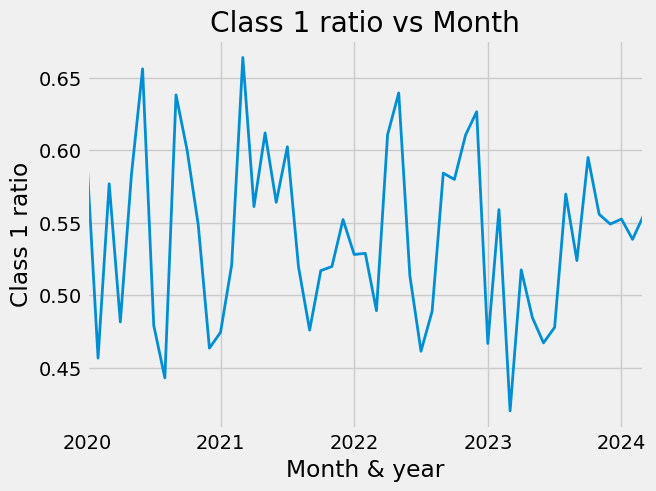

In [14]:
train_df['date_month'] = train_df['time'].dt.to_period('M')
group_df = train_df[train_df['time'].dt.year >= 2020]
ax = group_df.groupby('date_month')['target'].mean().plot()
ax.lines[0].set_linewidth(2)
ax.set_xlabel('Month & year')
ax.set_ylabel('Class 1 ratio')
ax.set_title('Class 1 ratio vs Month')
train_df = train_df.drop(columns='date_month')

### Visualize buy trades

In [15]:
import matplotlib.pyplot as plt
import mplfinance as mpf

if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_buy.index
    test_buy = train_buy.sample(plt_num, axis=0)

    for i, row in test_buy.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]

        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize sell trades

In [16]:
if CFG.create_dataset:
    plt_num = 3
    j = 1
    fig = plt.figure(figsize=(30, 6 * plt_num))

    buy_idxs = train_sell.index
    test_sell = train_sell.sample(plt_num, axis=0)

    for i, row in test_sell.iterrows():
        ticker = row['ticker']
        time = row['time']
        target = row['target']
        ttype = row['ttype']
        pattern = row['pattern']

        df_1h, _ = get_file(ticker)
        df_1h = df_1h[(df_1h['time'] >= time) & (df_1h['time'] <= time + timedelta(hours=target_offset))]
        
        ohlc = df_1h[['time', 'open', 'high', 'low', 'close', 'volume']].set_index('time')
        
        price = df_1h.iloc[0]['close']
        high_price = price * CFG.cls_target_ratio_tp
        low_price = price * (2 - CFG.cls_target_ratio_tp)

        ax = fig.add_subplot(plt_num, 1, j)
        mpf.plot(ohlc, type='candle', warn_too_much_data=1001, style='yahoo', ylabel='', tz_localize=True, ax=ax)
        
        if ttype == 'buy':
            ax.axhline(high_price, color='g')
            ax.axhline(low_price, color='r')
        else:
            ax.axhline(high_price, color='r')
            ax.axhline(low_price, color='g')
        ax.set_title(f'Ticker: {ticker}, price: {price}, pattern {pattern}, target: {target}', fontsize=20)
        j += 1
        
    fig.tight_layout()

### Visualize feature distributions

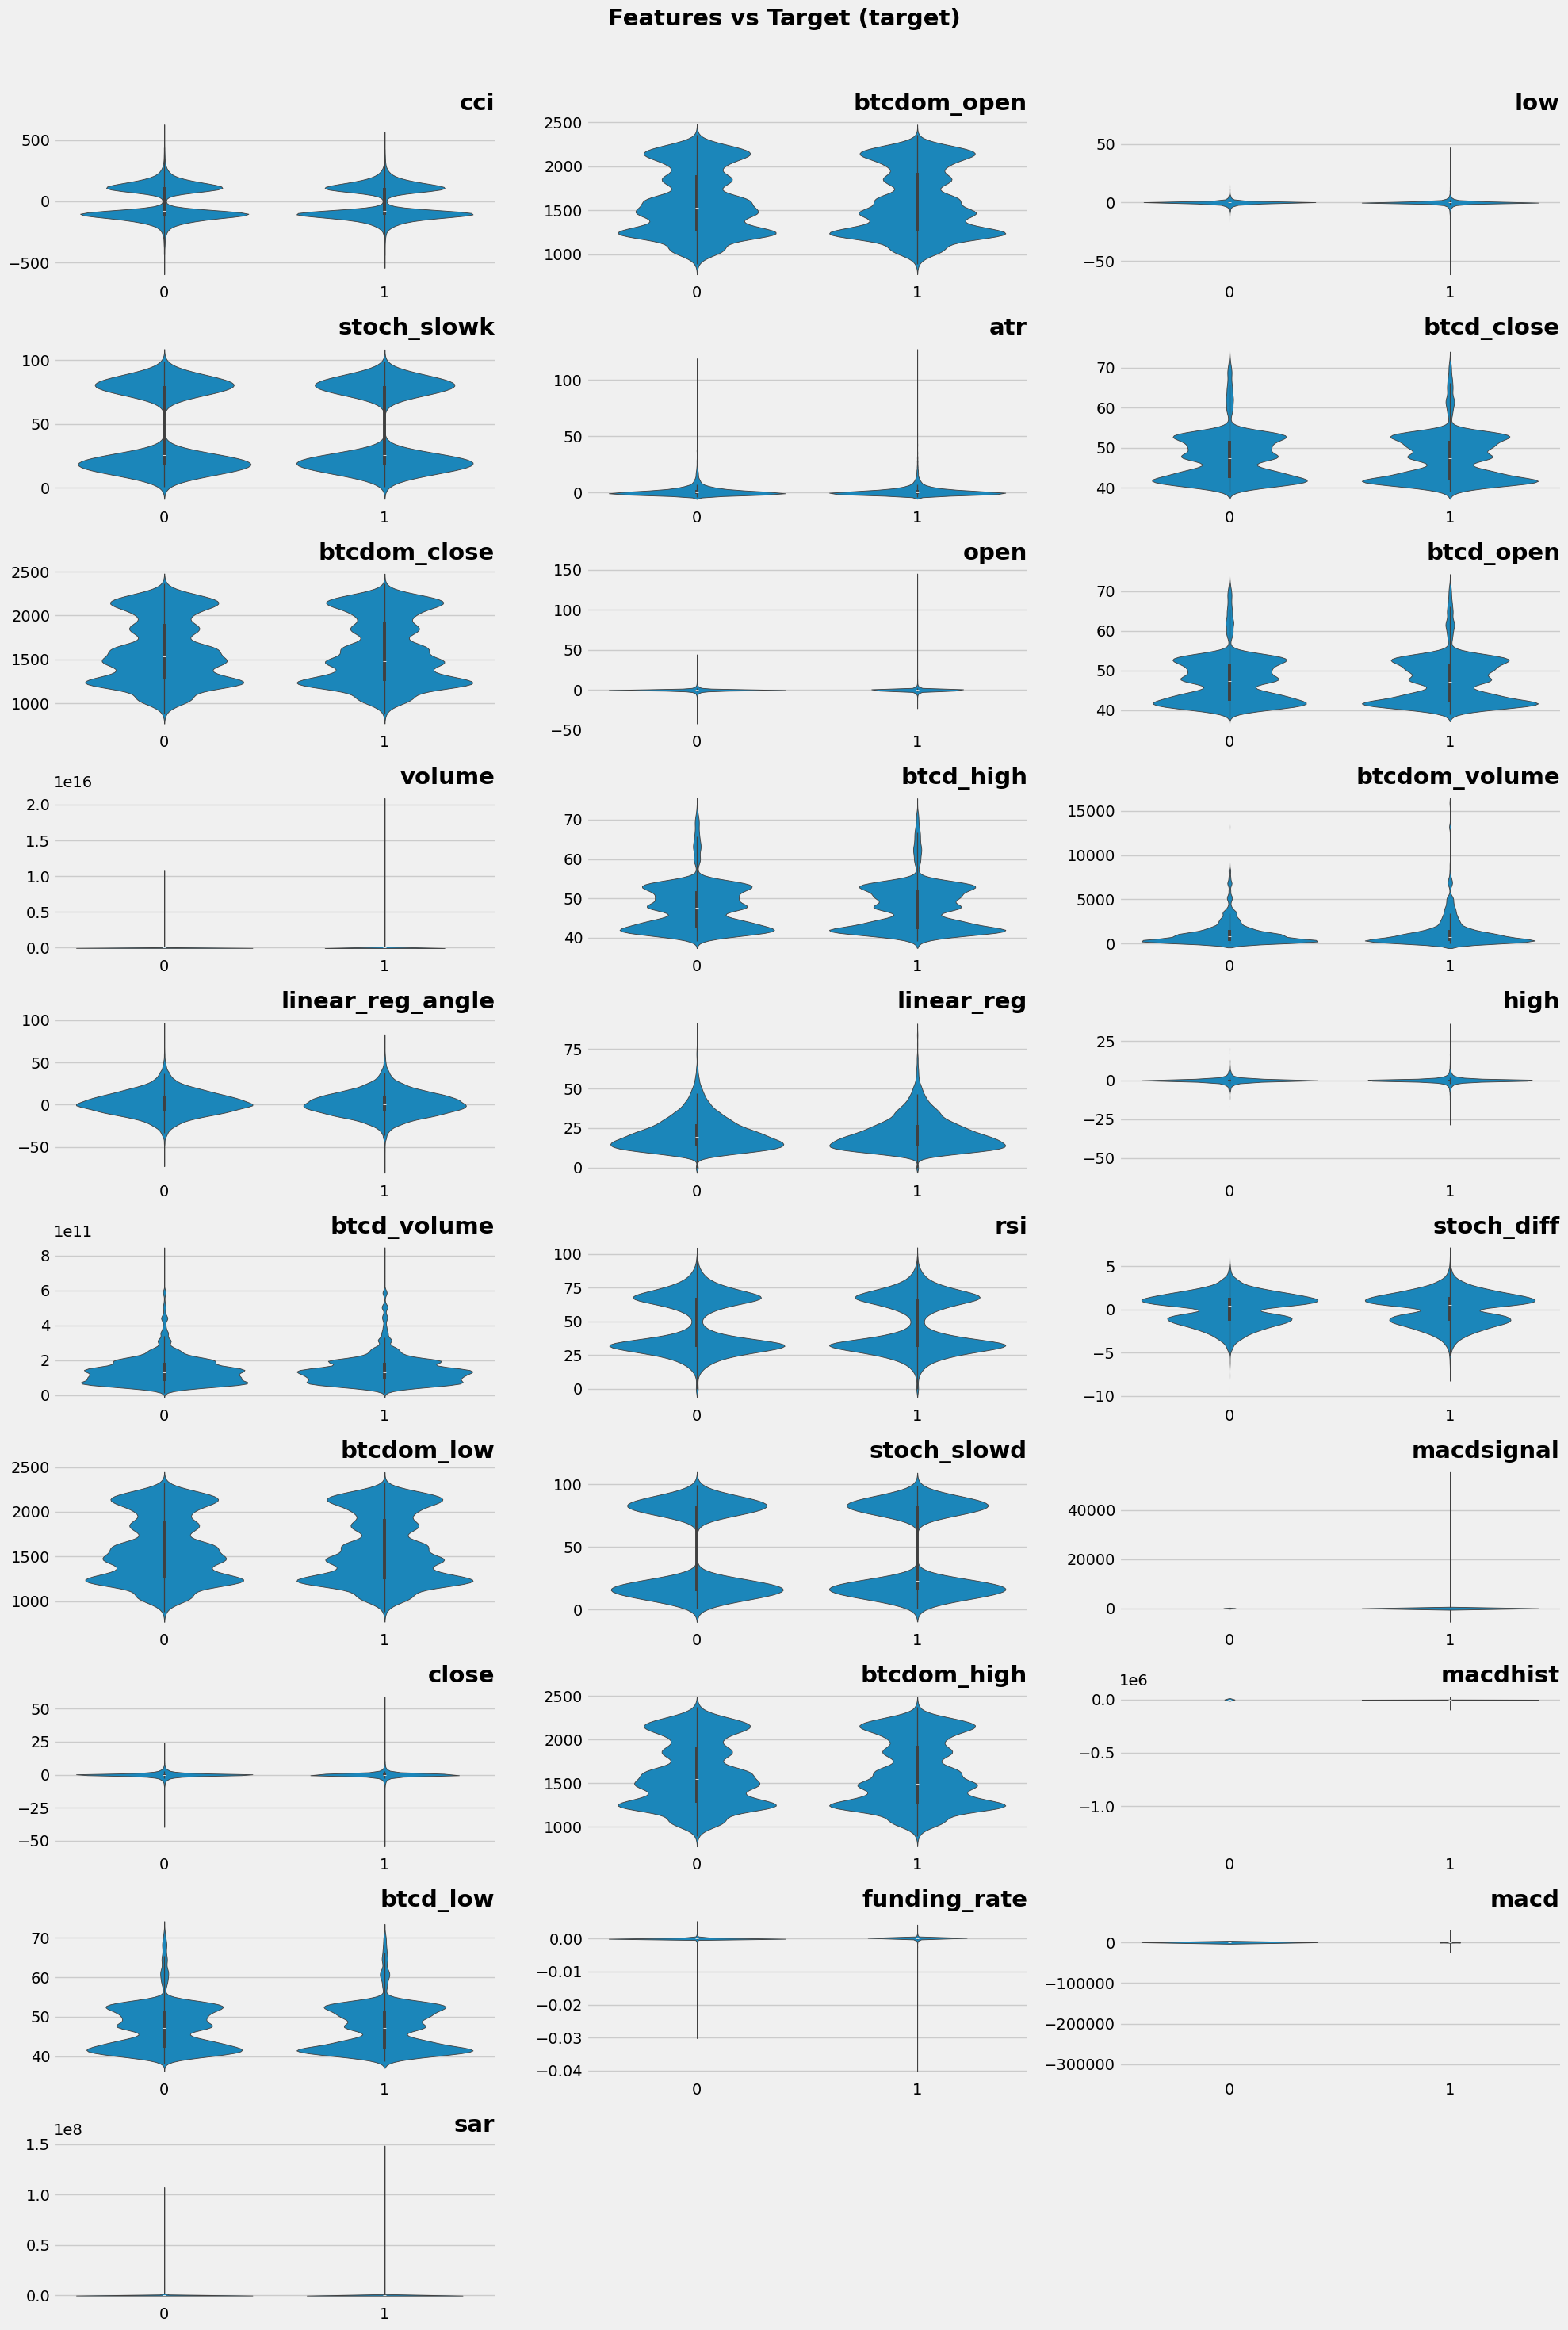

In [17]:
fi = pd.read_csv(f'model/feature_importance.csv')['Feature'].to_list()
cols = [c for c in fi if 'prev' not in c]
figsize = (20, 30)

def plot_target_violine(df, df_cols, n_rows, n_cols, target):
    fig = plt.figure(figsize=figsize)
    
    for idx, col in enumerate(df_cols):
        ax = plt.subplot(n_rows, n_cols, idx + 1)
        try:
            sns.violinplot(x=target, y=col, data=df)
        except ValueError:
            print(f"Can't find {col} in the dataframe")

        ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
        ax.set_xlabel(''); ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=21)

    
    fig.suptitle(f'Features vs Target ({target})\n\n\n', ha='center',  fontweight='bold', fontsize=21)
    # fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3)
    plt.tight_layout()
    plt.show()
    
n_cols = 3
n_rows = len(cols) // n_cols + 1
plot_target_violine(train_df, cols, n_rows=n_rows, n_cols=n_cols, target='target')

### Show the last signals

In [18]:
x = pd.read_pickle('signal_stat/buy_stat_1h.pkl')
x['ttype'] = 'buy'
y = pd.read_pickle('signal_stat/sell_stat_1h.pkl')
y['ttype'] = 'sell'
x = pd.concat([x, y]).sort_values('time').reset_index(drop=True)
x.loc[x['pattern'] == 'STOCH_RSI_Volume24', ['time', 'ticker', 'ttype', 'pattern']].tail(35)

,time,ticker,ttype,pattern
75790,2024-03-14 01:00:00,CTXCUSDT,buy,STOCH_RSI_Volume24
75791,2024-03-14 02:00:00,ROGUSDT,sell,STOCH_RSI_Volume24
75792,2024-03-14 03:00:00,BCUTUSDT,sell,STOCH_RSI_Volume24
75793,2024-03-14 03:00:00,FDUSDUSDT,sell,STOCH_RSI_Volume24
75794,2024-03-14 03:00:00,XWGUSDT,sell,STOCH_RSI_Volume24
75795,2024-03-14 03:00:00,XAVAUSDT,sell,STOCH_RSI_Volume24
75796,2024-03-14 03:00:00,SCPTUSDT,sell,STOCH_RSI_Volume24
75797,2024-03-14 04:00:00,SOLUSDT,sell,STOCH_RSI_Volume24
75798,2024-03-14 04:00:00,JUP_USDT,sell,STOCH_RSI_Volume24
75799,2024-03-14 04:00:00,ERTHAUSDT,sell,STOCH_RSI_Volume24


# Feature selection

### Select features with BORUTA feature importance

In [19]:
from shaphypetune import BoostBoruta
  
params = {
          'boosting_type': 'dart',
          'n_estimators': 1000,
          'learning_rate': 0.02,
          'max_depth': 10,
          'subsample' : 0.7,
          'colsample_bytree': 0.85,
          'num_leaves': 24,
          'verbosity': -1,
          'importance_type': 'gain',
          'max_bin': 255,
          'reg_alpha': 1e-6,
          'reg_lambda': 1e-7,
          'objective': 'binary',
          'metric': 'average_precision'
        }
features = [c for c in train_df.columns if c not in ['time', 'target', 'ticker', 'pattern', 'ttype']]



def boruta_selction(df):
    boruta_df_ = pd.DataFrame()

    X, y, time = df[features], df['target'], df['time']

    tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
    eval_metric = 'logloss'

    # Stratify based on Class and Alpha (3 types of conditions)
    for fold, (train_idx, val_idx) in enumerate(tss.split(time)):

        print(f'Fold: {fold}')
        # Split the dataset according to the fold indexes.
        X_train = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]

        clf = lgb.LGBMClassifier(**params)
        model = BoostBoruta(clf, importance_type='shap_importances', train_importance=False, max_iter=1000)
        try:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                      eval_metric='logloss', 
                      callbacks=[lgb.log_evaluation(100)])
        except RuntimeError:
            break

        boruta_importance_df = pd.DataFrame({'importance': model.ranking_}, index=X_train.columns).sort_index()
        if boruta_df_.shape[0] == 0:
            boruta_df_ = boruta_importance_df.copy()
        else:
            boruta_df_ += boruta_importance_df

    boruta_df_ = boruta_df_.sort_values('importance')
    boruta_df_ = boruta_df_.reset_index().rename({'index': 'Feature'}, axis=1)

    return boruta_df_


if CFG.select_features:
    boruta_df_ = boruta_selction(train_df)

### Select features with permutation importance and GBM feature importance

In [20]:
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

def lgbm_tuning(df, permut=False):
    outer_cv_score = [] # store all cv scores of outer loop inference

    perm_df_ = pd.DataFrame()
    feature_importances_ = pd.DataFrame()
    
    for fold in range(CFG.n_repeats):
        print(f'Repeat {blu}#{fold+1}')

        X, y, time = df[features], df['target'], df['time']
        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=CFG.n_folds, test_size=len(X) // int(CFG.n_folds * 1.5))
        eval_metric = 'logloss'
        
        oof = np.zeros(len(df))
        
        # Stratify based on Class and Alpha (3 types of conditions)
        for fold, (train_idx, val_idx) in enumerate(tss.split(time)):
            if fold == 0:
                first_val_idx = val_idx[0]
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[train_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[train_idx]
            y_val = y.iloc[val_idx]

            clf = lgb.LGBMClassifier(**params)
            clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                    eval_metric=eval_metric, 
                    callbacks=[lgb.log_evaluation(100)])

            val_preds = clf.predict_proba(X_val)[:,1]
            val_score = log_loss(y_val, val_preds)
            
            oof[val_idx] = val_preds
            best_iter = clf.best_iteration_

            print(f'Fold: {blu}{fold + 1:>3}{res}| loss: {blu}{val_score:.5f}{res}| Best iteration: {blu}{best_iter:>4}{res}')

            # gboost feature importance
            f_i = pd.DataFrame(sorted(zip(clf.feature_importances_, X.columns), 
                                      reverse=True, key=lambda x: x[1]), 
                                      columns=['Value','Feature'])

            if feature_importances_.shape[0] == 0:
                feature_importances_ = f_i.copy()
            else:
                feature_importances_['Value'] += f_i['Value']
            
            # permutation importance
            if permut:
                perm = PermutationImportance(clf, scoring=None, n_iter=1, 
                                             random_state=42, cv=None, refit=False).fit(X_val, y_val)

                perm_importance_df = pd.DataFrame({'importance': perm.feature_importances_}, 
                                                    index=X_val.columns).sort_index()

                if perm_df_.shape[0] == 0:
                    perm_df_ = perm_importance_df.copy()
                else:
                    perm_df_ += perm_importance_df

        outer_cv = log_loss(y[first_val_idx:], oof[first_val_idx:])
        outer_cv_score.append(outer_cv)

    print(f'{red} Outer Holdout avg score: {res} log_loss: {red}{np.mean(outer_cv_score):.5f}{res}')
    print(f'{"*" * 50}\n')
    
    if permut:
        perm_df_ = perm_df_.sort_values('importance', ascending=False)
        perm_df_ = perm_df_.reset_index().rename({'index': 'Feature'}, axis=1)
                                    
    feature_importances_ = feature_importances_.sort_values('Value', ascending=False).reset_index(drop=True)
    
    return perm_df_, feature_importances_, np.mean(outer_cv_score)


if CFG.select_features:
    perm_df_, feature_importances_, outer_cv_score = lgbm_tuning(train_df, permut=True)

### RFE feature selection

In [21]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

def rfe_selection(df):
    params = {
          'penalty': 'l2',
          'max_iter': 10000,
          'C': 1
        }

    scaler = StandardScaler()
    X, y = df[features], df['target']
    X = scaler.fit_transform(X)
        
    estimator = LogisticRegression(**params)
    selector = RFECV(estimator, min_features_to_select=50, step=0.025, cv=5, verbose=1)
    selector = selector.fit(X, y)
    rfe_df_ = pd.DataFrame({'importance': selector.ranking_}, index=features).sort_index()
    rfe_df_ = rfe_df_.reset_index().rename({'index': 'Feature'}, axis=1)
    return rfe_df_

if CFG.select_features:
    rfe_df_ = rfe_selection(train_df)

### Combine importances and save them

In [22]:
if CFG.select_features:
    # boruta_df_['rank'] = boruta_df_['importance'].rank()
    perm_df_['rank'] = perm_df_['importance'].rank(ascending=False)
    rfe_df_['rank'] = rfe_df_['importance']
    feature_importances_['rank'] = feature_importances_['Value'].rank(ascending=False)

    fi = pd.concat([perm_df_[['Feature','rank']], feature_importances_[['Feature','rank']], rfe_df_[['Feature','rank']]])
                    # boruta_df_[['Feature','rank']]])
    fi = fi.groupby('Feature')['rank'].sum().sort_values().reset_index()
    fi.to_csv(f'model/feature_importance.csv')
else:
    fi = pd.read_csv(f'model/feature_importance.csv')

### Load selected features

In [23]:
def exclude_corr_features(features, corr_thresh):
    features_to_select = features.copy()
    correlations = train_df.loc[:, features_to_select].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']] 
    correlations.columns = ['feature_1', 'feature_2', 'corr']

    correlations = pd.merge(left=correlations, right=fi, how='left', left_on='feature_1', right_on='Feature')
    correlations = correlations.drop(columns='Feature')
    correlations = correlations.sort_values(['corr', 'rank'], ascending=[False, True])
    correlations = correlations[::2]

    features_to_exclude = set()
    correlations = correlations[correlations['corr'] > corr_thresh]

    for _, row in correlations.iterrows():
        feature_1 = row['feature_1']
        feature_2 = row['feature_2']

        if feature_1 in features_to_exclude:
            continue

        features_to_exclude.add(feature_2)

    return features_to_exclude


def prepare_features(fi, feature_num):
    ''' Get features, sort them by their time appearance and return for using in train and inference'''
    # exclude some features 
    fi = fi['Feature']
    fi = fi[:feature_num]
    feature_dict = defaultdict(list)
    features = list()
    
    for f in fi:
        if f == 'volume_24':
            feature_dict[0].append(f)
            continue
        period = f.split('_')
        if period[-1].isdigit():
            feature_dict[int(period[-1])].append('_'.join(period[:-2]))
        else:
            feature_dict[0].append(f)

    feature_dict = dict(sorted(feature_dict.items()))
    
    for item in feature_dict.items():
        if item[0] > 0:
            features.extend([i + f'_prev_{item[0]}' for i in item[1]])
        else:
            features.extend([i for i in item[1]])

    feature_dict['features'] = features # + ['Pattern_Trend', 'STOCH_RSI']

    return features, feature_dict

corr_thresh = 0.9208549086841545
train_df['weekday'] = train_df['time'].dt.weekday
fi = pd.read_csv('model/feature_importance.csv')
feature_num = 132 # 80
features, feature_dict = prepare_features(fi, feature_num)
features_to_exclude = exclude_corr_features(features, corr_thresh)
features = [f for f in features if f not in features_to_exclude]
features = list(features) + ['weekday']
display(features)

['cci',
 'btcdom_open',
 'low',
 'atr',
 'btcdom_volume_prev_4',
 'rsi_prev_4',
 'stoch_diff_prev_4',
 'btcdom_volume_prev_8',
 'cci_prev_8',
 'stoch_slowd_prev_8',
 'btcdom_volume_prev_12',
 'btcdom_volume_prev_16',
 'stoch_slowk_prev_16',
 'rsi_prev_16',
 'btcdom_volume_prev_20',
 'high_prev_24',
 'btcdom_volume_prev_24',
 'stoch_diff_prev_24',
 'stoch_diff_prev_28',
 'btcdom_volume_prev_32',
 'rsi_prev_32',
 'cci_prev_32',
 'rsi_prev_36',
 'low_prev_36',
 'btcdom_volume_prev_40',
 'low_prev_40',
 'btcdom_volume_prev_44',
 'close_prev_44',
 'stoch_diff_prev_44',
 'cci_prev_44',
 'cci_prev_48',
 'open_prev_48',
 'stoch_slowk_prev_48',
 'btcd_volume_prev_48',
 'rsi_prev_52',
 'atr_prev_52',
 'stoch_diff_prev_52',
 'stoch_diff_prev_56',
 'btcdom_volume_prev_56',
 'btcdom_volume_prev_68',
 'stoch_slowk_prev_68',
 'rsi_prev_68',
 'low_prev_68',
 'btcd_volume_prev_72',
 'high_prev_72',
 'low_prev_72',
 'btcdom_volume_prev_72',
 'btcdom_volume_prev_80',
 'high_prev_80',
 'stoch_slowd_prev_8

# Train

### Fucntion to remove features that correlate with other features too much and are not too important

### Functions for train and optimization

In [24]:
val_idxs = list()
prec_score_list = list()
with open(f'model/bybit_tickers.json', 'r') as f:
    bybit_tickers = json.load(f)

def confident_score(y, oof, low_bound, high_bound):
    ''' Consider only high confident objects for accuracy and precision scores calculation;
        object probability must be lower than low_bound or higher than high_bound '''
    pred_conf = np.zeros_like(oof)
    pred_conf[oof > high_bound] = 1
    pred_conf_prec = pred_conf[(oof > high_bound)]
    y_conf_prec = y.values.reshape(-1,1)[(oof > high_bound)]
    if y_conf_prec.shape[0] == 0:
        return 0, 0, 0
    return precision_score(y_conf_prec, pred_conf_prec), y_conf_prec.shape[0], y_conf_prec.shape[0]/y.shape[0]

def model_train(df, features, params, n_folds, low_bound, high_bound, train_test, verbose=False): 
    X, time = df[features], df['time']
    y = df['target']
    
    if train_test == 'fold':
        oof = np.zeros([len(df), 1])

        tss = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=n_folds, test_size=(len(df) * 2) // (n_folds * 3))

        if verbose:
            print(f"Training with {len(features)} features")
        
        for fold, (fit_idx, val_idx) in enumerate(tss.split(time)):
            # select only those val_idxs that correspond to 
            # time = max train dataset time + 96 hours to prevent data leakage
            max_time = time[fit_idx].max() + pd.to_timedelta(96, unit='h')
            # also select only tickers from ByBit for validation because we trade on ByBit only
            val_idx = time[(time > max_time) & (df['ticker'].isin(bybit_tickers))].index.tolist()
            
            val_idxs.extend(val_idx)
            
            if verbose:
                print(f'Fold #{fold + 1}')
            
            # Split the dataset according to the fold indexes.
            X_train = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_train = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            if verbose:
                display(y_val.value_counts(normalize=True))
                display(df.loc[val_idx[0], 'time'])
                display(df.loc[val_idx[-1], 'time'])
                callbacks = [lgb.log_evaluation(100)]
            else:
                callbacks = []
            
            model_lgb = lgb.LGBMClassifier(**params)
            model_lgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
                          eval_metric='logloss', callbacks=callbacks)

            val_preds = model_lgb.predict_proba(X_val)
        
            val_score = log_loss(y_val, val_preds)
            prec_score, prec_obj_num, prec_obj_pct = confident_score(y_val, val_preds[:, 1], low_bound, high_bound)
            prec_score_list.append(prec_score)
            if verbose:
                print(f'Logloss: {val_score}, Confident objects precision: {prec_score}\n'
                      f'Number of confident objects {prec_obj_num}, % of confident objects: {prec_obj_pct}\n'
                      f'Number of profitable objects: {round((2 * prec_score -  1) * prec_obj_num)}')
            oof[val_idx, 0] = val_preds[:,1]
        
        return oof, model_lgb, sorted(list(set(val_idxs)))
    elif train_test == 'full':
        print('Train on full data')
        X, y = df[features], df['target']
        
        model_lgb = lgb.LGBMClassifier(**params)
        model_lgb.fit(X, y, eval_set=[(X, y)], eval_metric='logloss', callbacks = [lgb.log_evaluation(100)])
        
        return np.zeros([df.shape[0], 1]), model_lgb, None

def objective(trial):
    params = {
        # Main parameters
#                     'device': 'gpu',
#                     'gpu_platform_id': 0,
#                     'gpu_device_id': 0,
        'objective': 'binary',
        'metric': 'average_precision',
        'boosting_type': trial.suggest_categorical('boosting_type', ['dart', 'goss', 'gbdt']),   
        # Hyperparamters (in order of importance decreasing)
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),  # max number of trees in model
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 3e-1),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True), # L1,  alias: lambda_l1
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True), # L2, alias: lambda_l2
         # decrease to deal with overfit
        'max_depth': trial.suggest_int('max_depth', 4, 10),   # tree max depth 
         # decrease to deal with overfit
        'num_leaves': trial.suggest_int('num_leaves', 4, 512),  # Max number of leaves in one tree
                                                                # should be ~ 2**(max_depth-1)
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9), # Randomly select a subset of features 
                                                                   # if colsample_bytree < 1.0
                                                                   # alias:feature_fraction
        # increase for accuracy, decrease to deal with overfit
        'max_bin': trial.suggest_int('max_bin', 32, 255), # Max number of bins that feature values will be bucketed in
        # increase to deal with overfit
        'subsample_freq': 1, # Perform bagging at every k iteration, alias: bagging_freq

#           'subsample_for_bin': 200000, # Number of data that sampled to construct feature discrete bins; setting this 
                                     # to larger value will give better training result but may increase train time 
#           'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),  # this can reduce the effect of noises in 
                                                                       # categorical features, especially for 
                                                                       # categories with few data
        'is_unbalance': trial.suggest_categorical('is_unbalance', [True, False]),                                                   
        'verbose': -1,
        'importance_type': 'gain',
        
        'high_bound': 0.5,
        'feature_num': trial.suggest_int('feature_num', 50, 500),
        'corr_thresh': trial.suggest_float('corr_thresh', 0.5, 0.99)
    }

    if params['is_unbalance'] is True:
        params['class_weight'] = 'balanced'
    
    if params['boosting_type'] != 'goss':
        params['subsample'] = trial.suggest_float('subsample', 0.3, 0.9)

    high_bound = params['high_bound']
    low_bound = 1 - high_bound
    del params['high_bound']

    corr_thresh = params['corr_thresh']
    del params['corr_thresh']
    
    fi = pd.read_csv(f'model/feature_importance.csv')
    feature_num = params['feature_num']
    del params['feature_num']
    
    train_df['weekday'] = train_df['time'].dt.weekday
    features, _ = prepare_features(fi, feature_num)
    features = features + ['weekday']

    features_to_exclude = exclude_corr_features(features, corr_thresh)
    features = [f for f in features if f not in features_to_exclude]
    
    oof, __, val_idxs = model_train(train_df, features, params, n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                    train_test='fold')
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)
    oof_val_score = log_loss(y, oof)
    res = oof_conf_obj_num * (oof_conf_prec_score-0.55) * 100
    # save dataframe with additional information
    df_optuna_more_info = pd.read_csv('model/optuna_lgbm_info.csv')
    profit_objects = round(oof_conf_obj_num * (2 * oof_conf_prec_score - 1))
    tmp = pd.DataFrame({'value': [res], 'oof_conf_prec_score': [oof_conf_prec_score], 
                        'profit_objects': [profit_objects], 'oof_val_score': [oof_val_score], 
                        'oof_conf_obj_num': [oof_conf_obj_num], 'oof_conf_obj_pct': [oof_conf_obj_pct], 
                        })
    df_optuna_more_info = pd.concat([df_optuna_more_info, tmp])
    df_optuna_more_info.to_csv('model/optuna_lgbm_info.csv', index=False)
    return res

### Train / optimize process

In [34]:
params = {
            'boosting_type': 'dart',
            'n_estimators': 2583,
            'learning_rate': 0.0002346215193142581,
            'is_unbalance': True,
            'class_weight': 'balanced',
            'colsample_bytree': 0.8226162386453161,
            'subsample': 0.40571361458738814,
            'max_depth': 10,
            'num_leaves': 23,
            'max_bin': 51,
            'reg_alpha': 7.2400478513365e-05,
            'reg_lambda': 3.978472026116517e-06,
            'subsample_freq': 1,
            'objective': 'binary',
            'importance_type': 'gain',
            'metric': 'average_precision',
            'verbosity': -1
        }

train_test = 'full' # fold, full
high_bound = 0.5
low_bound = 1 - high_bound
last_date = '2024-01-28'

if CFG.optimize:
    df_optuna_more_info = pd.DataFrame(columns=['value', 'oof_conf_prec_score', 'profit_objects', 
                                                'oof_val_score', 'oof_conf_obj_num', 'oof_conf_obj_pct'])
    df_optuna_more_info.to_csv('model/optuna_lgbm_info.csv', index=False)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=500)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    df_optuna = study.trials_dataframe()
    df_optuna = df_optuna.sort_values('value', ascending=False)
    df_optuna.to_csv(f'optuna_lgbm.csv')

    display(df_optuna.head(10))
elif train_test == 'fold':
    # fold
    oof, _, val_idxs = model_train(train_df, features, params, n_folds=8, low_bound=low_bound, high_bound=high_bound, 
                                   train_test=train_test, verbose=True)
    y = train_df['target'][val_idxs]
    oof = oof[val_idxs]
    oof_val_score = log_loss(y, oof)
    oof_conf_prec_score, oof_conf_obj_num, oof_conf_obj_pct = confident_score(y, oof, low_bound, high_bound)

    print(f'Total fold Logloss: {oof_val_score}, Total confident objects precision: {oof_conf_prec_score}\n'
            f'Number of confident objects: {oof_conf_obj_num}, Total % of confident objects: {oof_conf_obj_pct}\n' 
            f'Number of profitable objects: {round(( 2 * oof_conf_prec_score - 1) * oof_conf_obj_num)}')
elif train_test == 'full': 
    oof, model, val_idxs = model_train(train_df[train_df['time'] < last_date], features, params, n_folds=5, low_bound=low_bound, 
                                       high_bound=high_bound, train_test=train_test, verbose=True)
    joblib.dump(model, f'model/lgbm.pkl') 
    # save feature dictionary for further inference
    with open(f'model/features.json', 'w') as f:
        json.dump(feature_dict, f)

Train on full data
[100]	training's binary_logloss: 0.692535	training's average_precision: 0.704394
[200]	training's binary_logloss: 0.692174	training's average_precision: 0.7052
[300]	training's binary_logloss: 0.691751	training's average_precision: 0.707401
[400]	training's binary_logloss: 0.691304	training's average_precision: 0.707362
[500]	training's binary_logloss: 0.690803	training's average_precision: 0.708051
[600]	training's binary_logloss: 0.690549	training's average_precision: 0.708125
[700]	training's binary_logloss: 0.690127	training's average_precision: 0.708637
[800]	training's binary_logloss: 0.689794	training's average_precision: 0.708498
[900]	training's binary_logloss: 0.689355	training's average_precision: 0.708858
[1000]	training's binary_logloss: 0.689028	training's average_precision: 0.709285
[1100]	training's binary_logloss: 0.688627	training's average_precision: 0.709497
[1200]	training's binary_logloss: 0.688368	training's average_precision: 0.70957
[1300]	tr

In [26]:
# Training with 119 features
# Fold #1
# 1    0.539451
# 0    0.460549
# Name: target, dtype: float64Timestamp('2022-07-21 21:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.69209	training's average_precision: 0.770468	valid_1's binary_logloss: 0.693046	valid_1's average_precision: 0.577666
# [200]	training's binary_logloss: 0.691457	training's average_precision: 0.773621	valid_1's binary_logloss: 0.692976	valid_1's average_precision: 0.58518
# [300]	training's binary_logloss: 0.690703	training's average_precision: 0.774821	valid_1's binary_logloss: 0.692877	valid_1's average_precision: 0.585038
# [400]	training's binary_logloss: 0.689923	training's average_precision: 0.774741	valid_1's binary_logloss: 0.692853	valid_1's average_precision: 0.578121
# [500]	training's binary_logloss: 0.689056	training's average_precision: 0.775973	valid_1's binary_logloss: 0.692724	valid_1's average_precision: 0.577784
# [600]	training's binary_logloss: 0.688633	training's average_precision: 0.77899	valid_1's binary_logloss: 0.692651	valid_1's average_precision: 0.577288
# [700]	training's binary_logloss: 0.687894	training's average_precision: 0.779678	valid_1's binary_logloss: 0.692639	valid_1's average_precision: 0.574195
# [800]	training's binary_logloss: 0.687362	training's average_precision: 0.7792	valid_1's binary_logloss: 0.692575	valid_1's average_precision: 0.572486
# [900]	training's binary_logloss: 0.686589	training's average_precision: 0.779366	valid_1's binary_logloss: 0.692554	valid_1's average_precision: 0.573201
# [1000]	training's binary_logloss: 0.686006	training's average_precision: 0.779179	valid_1's binary_logloss: 0.692511	valid_1's average_precision: 0.57319
# [1100]	training's binary_logloss: 0.685307	training's average_precision: 0.779254	valid_1's binary_logloss: 0.692467	valid_1's average_precision: 0.576815
# [1200]	training's binary_logloss: 0.684846	training's average_precision: 0.779186	valid_1's binary_logloss: 0.69241	valid_1's average_precision: 0.578044
# [1300]	training's binary_logloss: 0.684248	training's average_precision: 0.7807	valid_1's binary_logloss: 0.692381	valid_1's average_precision: 0.578865
# [1400]	training's binary_logloss: 0.683424	training's average_precision: 0.78125	valid_1's binary_logloss: 0.692301	valid_1's average_precision: 0.581271
# [1500]	training's binary_logloss: 0.683001	training's average_precision: 0.781967	valid_1's binary_logloss: 0.692265	valid_1's average_precision: 0.581874
# [1600]	training's binary_logloss: 0.682275	training's average_precision: 0.78277	valid_1's binary_logloss: 0.692236	valid_1's average_precision: 0.580754
# [1700]	training's binary_logloss: 0.681532	training's average_precision: 0.783544	valid_1's binary_logloss: 0.692177	valid_1's average_precision: 0.580133
# [1800]	training's binary_logloss: 0.680898	training's average_precision: 0.784294	valid_1's binary_logloss: 0.692176	valid_1's average_precision: 0.580762
# [1900]	training's binary_logloss: 0.6802	training's average_precision: 0.784249	valid_1's binary_logloss: 0.692128	valid_1's average_precision: 0.580587
# [2000]	training's binary_logloss: 0.679607	training's average_precision: 0.784543	valid_1's binary_logloss: 0.692061	valid_1's average_precision: 0.581092
# [2100]	training's binary_logloss: 0.678742	training's average_precision: 0.785064	valid_1's binary_logloss: 0.691995	valid_1's average_precision: 0.581287
# [2200]	training's binary_logloss: 0.678056	training's average_precision: 0.785405	valid_1's binary_logloss: 0.691933	valid_1's average_precision: 0.581927
# [2300]	training's binary_logloss: 0.677252	training's average_precision: 0.785953	valid_1's binary_logloss: 0.691857	valid_1's average_precision: 0.581718
# [2400]	training's binary_logloss: 0.676416	training's average_precision: 0.786559	valid_1's binary_logloss: 0.691806	valid_1's average_precision: 0.581423
# [2500]	training's binary_logloss: 0.675786	training's average_precision: 0.78682	valid_1's binary_logloss: 0.691759	valid_1's average_precision: 0.582051
# Logloss: 0.6917421137029467, Confident objects precision: 0.5738111336488618
# Number of confident objects 4437, % of confident objects: 0.5436167605978927
# Number of profitable objects: 655
# Fold #2
# 1    0.544087
# 0    0.455913
# Name: target, dtype: float64Timestamp('2022-10-19 16:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692198	training's average_precision: 0.752466	valid_1's binary_logloss: 0.692987	valid_1's average_precision: 0.591499
# [200]	training's binary_logloss: 0.691637	training's average_precision: 0.75481	valid_1's binary_logloss: 0.692976	valid_1's average_precision: 0.58814
# [300]	training's binary_logloss: 0.690956	training's average_precision: 0.758607	valid_1's binary_logloss: 0.692854	valid_1's average_precision: 0.580826
# [400]	training's binary_logloss: 0.690259	training's average_precision: 0.758456	valid_1's binary_logloss: 0.69275	valid_1's average_precision: 0.580582
# [500]	training's binary_logloss: 0.68947	training's average_precision: 0.758871	valid_1's binary_logloss: 0.692609	valid_1's average_precision: 0.577692
# [600]	training's binary_logloss: 0.689071	training's average_precision: 0.759263	valid_1's binary_logloss: 0.692515	valid_1's average_precision: 0.579785
# [700]	training's binary_logloss: 0.688406	training's average_precision: 0.759738	valid_1's binary_logloss: 0.69248	valid_1's average_precision: 0.581468
# [800]	training's binary_logloss: 0.687922	training's average_precision: 0.759781	valid_1's binary_logloss: 0.692412	valid_1's average_precision: 0.582707
# [900]	training's binary_logloss: 0.687225	training's average_precision: 0.759989	valid_1's binary_logloss: 0.692327	valid_1's average_precision: 0.581577
# [1000]	training's binary_logloss: 0.686706	training's average_precision: 0.76037	valid_1's binary_logloss: 0.692252	valid_1's average_precision: 0.583262
# [1100]	training's binary_logloss: 0.686075	training's average_precision: 0.760545	valid_1's binary_logloss: 0.692192	valid_1's average_precision: 0.583103
# [1200]	training's binary_logloss: 0.685662	training's average_precision: 0.761316	valid_1's binary_logloss: 0.692171	valid_1's average_precision: 0.584732
# [1300]	training's binary_logloss: 0.685122	training's average_precision: 0.762178	valid_1's binary_logloss: 0.692035	valid_1's average_precision: 0.58409
# [1400]	training's binary_logloss: 0.684381	training's average_precision: 0.762593	valid_1's binary_logloss: 0.691939	valid_1's average_precision: 0.583352
# [1500]	training's binary_logloss: 0.684003	training's average_precision: 0.762876	valid_1's binary_logloss: 0.691922	valid_1's average_precision: 0.582504
# [1600]	training's binary_logloss: 0.683349	training's average_precision: 0.763618	valid_1's binary_logloss: 0.691868	valid_1's average_precision: 0.581705
# [1700]	training's binary_logloss: 0.682666	training's average_precision: 0.763468	valid_1's binary_logloss: 0.691822	valid_1's average_precision: 0.581785
# [1800]	training's binary_logloss: 0.682082	training's average_precision: 0.763723	valid_1's binary_logloss: 0.691793	valid_1's average_precision: 0.58218
# [1900]	training's binary_logloss: 0.681452	training's average_precision: 0.764247	valid_1's binary_logloss: 0.691679	valid_1's average_precision: 0.581743
# [2000]	training's binary_logloss: 0.680939	training's average_precision: 0.764557	valid_1's binary_logloss: 0.691642	valid_1's average_precision: 0.581285
# [2100]	training's binary_logloss: 0.68019	training's average_precision: 0.765043	valid_1's binary_logloss: 0.691513	valid_1's average_precision: 0.580209
# [2200]	training's binary_logloss: 0.679573	training's average_precision: 0.765342	valid_1's binary_logloss: 0.691463	valid_1's average_precision: 0.580838
# [2300]	training's binary_logloss: 0.678822	training's average_precision: 0.765871	valid_1's binary_logloss: 0.691406	valid_1's average_precision: 0.58108
# [2400]	training's binary_logloss: 0.678062	training's average_precision: 0.766463	valid_1's binary_logloss: 0.691259	valid_1's average_precision: 0.580332
# [2500]	training's binary_logloss: 0.67748	training's average_precision: 0.766908	valid_1's binary_logloss: 0.691174	valid_1's average_precision: 0.580669
# Logloss: 0.6911291529785247, Confident objects precision: 0.5684039087947883
# Number of confident objects 4912, % of confident objects: 0.6842178576403399
# Number of profitable objects: 672
# Fold #3
# 1    0.539116
# 0    0.460884
# Name: target, dtype: float64Timestamp('2023-02-13 04:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692264	training's average_precision: 0.751548	valid_1's binary_logloss: 0.6931	valid_1's average_precision: 0.590534
# [200]	training's binary_logloss: 0.691729	training's average_precision: 0.752837	valid_1's binary_logloss: 0.693108	valid_1's average_precision: 0.576984
# [300]	training's binary_logloss: 0.691103	training's average_precision: 0.754096	valid_1's binary_logloss: 0.69305	valid_1's average_precision: 0.586109
# [400]	training's binary_logloss: 0.690448	training's average_precision: 0.755129	valid_1's binary_logloss: 0.693032	valid_1's average_precision: 0.58586
# [500]	training's binary_logloss: 0.689727	training's average_precision: 0.75606	valid_1's binary_logloss: 0.69301	valid_1's average_precision: 0.584361
# [600]	training's binary_logloss: 0.689373	training's average_precision: 0.756833	valid_1's binary_logloss: 0.692976	valid_1's average_precision: 0.584933
# [700]	training's binary_logloss: 0.688765	training's average_precision: 0.756212	valid_1's binary_logloss: 0.692937	valid_1's average_precision: 0.584914
# [800]	training's binary_logloss: 0.688307	training's average_precision: 0.756038	valid_1's binary_logloss: 0.692885	valid_1's average_precision: 0.582143
# [900]	training's binary_logloss: 0.687673	training's average_precision: 0.75683	valid_1's binary_logloss: 0.692854	valid_1's average_precision: 0.581877
# [1000]	training's binary_logloss: 0.687184	training's average_precision: 0.757204	valid_1's binary_logloss: 0.692799	valid_1's average_precision: 0.582629
# [1100]	training's binary_logloss: 0.6866	training's average_precision: 0.757569	valid_1's binary_logloss: 0.692802	valid_1's average_precision: 0.582106
# [1200]	training's binary_logloss: 0.686212	training's average_precision: 0.757694	valid_1's binary_logloss: 0.692788	valid_1's average_precision: 0.585606
# [1300]	training's binary_logloss: 0.685707	training's average_precision: 0.758437	valid_1's binary_logloss: 0.692777	valid_1's average_precision: 0.586998
# [1400]	training's binary_logloss: 0.685015	training's average_precision: 0.758921	valid_1's binary_logloss: 0.692766	valid_1's average_precision: 0.588349
# [1500]	training's binary_logloss: 0.684659	training's average_precision: 0.759107	valid_1's binary_logloss: 0.692779	valid_1's average_precision: 0.587265
# [1600]	training's binary_logloss: 0.684034	training's average_precision: 0.759683	valid_1's binary_logloss: 0.692778	valid_1's average_precision: 0.587504
# [1700]	training's binary_logloss: 0.6834	training's average_precision: 0.759887	valid_1's binary_logloss: 0.692705	valid_1's average_precision: 0.587509
# [1800]	training's binary_logloss: 0.68286	training's average_precision: 0.760373	valid_1's binary_logloss: 0.692696	valid_1's average_precision: 0.585683
# [1900]	training's binary_logloss: 0.682272	training's average_precision: 0.760774	valid_1's binary_logloss: 0.692683	valid_1's average_precision: 0.58649
# [2000]	training's binary_logloss: 0.681779	training's average_precision: 0.760939	valid_1's binary_logloss: 0.692637	valid_1's average_precision: 0.586936
# [2100]	training's binary_logloss: 0.681065	training's average_precision: 0.76069	valid_1's binary_logloss: 0.692609	valid_1's average_precision: 0.586403
# [2200]	training's binary_logloss: 0.680494	training's average_precision: 0.761188	valid_1's binary_logloss: 0.692595	valid_1's average_precision: 0.585274
# [2300]	training's binary_logloss: 0.679819	training's average_precision: 0.761405	valid_1's binary_logloss: 0.692609	valid_1's average_precision: 0.584042
# [2400]	training's binary_logloss: 0.6791	training's average_precision: 0.761994	valid_1's binary_logloss: 0.692551	valid_1's average_precision: 0.585199
# [2500]	training's binary_logloss: 0.678551	training's average_precision: 0.762164	valid_1's binary_logloss: 0.692492	valid_1's average_precision: 0.586605
# Logloss: 0.6924845094874499, Confident objects precision: 0.5970149253731343
# Number of confident objects 2278, % of confident objects: 0.3728314238952537
# Number of profitable objects: 442
# Fold #4
# 1    0.547158
# 0    0.452842
# Name: target, dtype: float64Timestamp('2023-04-28 01:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692272	training's average_precision: 0.742995	valid_1's binary_logloss: 0.693159	valid_1's average_precision: 0.578894
# [200]	training's binary_logloss: 0.691743	training's average_precision: 0.746081	valid_1's binary_logloss: 0.693146	valid_1's average_precision: 0.575479
# [300]	training's binary_logloss: 0.691122	training's average_precision: 0.746934	valid_1's binary_logloss: 0.69316	valid_1's average_precision: 0.572625
# [400]	training's binary_logloss: 0.690468	training's average_precision: 0.745586	valid_1's binary_logloss: 0.693148	valid_1's average_precision: 0.574656
# [500]	training's binary_logloss: 0.689727	training's average_precision: 0.747685	valid_1's binary_logloss: 0.693146	valid_1's average_precision: 0.572138
# [600]	training's binary_logloss: 0.689381	training's average_precision: 0.748245	valid_1's binary_logloss: 0.693181	valid_1's average_precision: 0.572137
# [700]	training's binary_logloss: 0.688762	training's average_precision: 0.748754	valid_1's binary_logloss: 0.693142	valid_1's average_precision: 0.576634
# [800]	training's binary_logloss: 0.688291	training's average_precision: 0.749233	valid_1's binary_logloss: 0.693123	valid_1's average_precision: 0.58179
# [900]	training's binary_logloss: 0.687653	training's average_precision: 0.749866	valid_1's binary_logloss: 0.693114	valid_1's average_precision: 0.581355
# [1000]	training's binary_logloss: 0.687171	training's average_precision: 0.750215	valid_1's binary_logloss: 0.693087	valid_1's average_precision: 0.584859
# [1100]	training's binary_logloss: 0.686599	training's average_precision: 0.750346	valid_1's binary_logloss: 0.693099	valid_1's average_precision: 0.582274
# [1200]	training's binary_logloss: 0.686214	training's average_precision: 0.750566	valid_1's binary_logloss: 0.693123	valid_1's average_precision: 0.582562
# [1300]	training's binary_logloss: 0.685724	training's average_precision: 0.750733	valid_1's binary_logloss: 0.693088	valid_1's average_precision: 0.582413
# [1400]	training's binary_logloss: 0.685045	training's average_precision: 0.750955	valid_1's binary_logloss: 0.693113	valid_1's average_precision: 0.582393
# [1500]	training's binary_logloss: 0.684696	training's average_precision: 0.751133	valid_1's binary_logloss: 0.693068	valid_1's average_precision: 0.583699
# [1600]	training's binary_logloss: 0.684096	training's average_precision: 0.751005	valid_1's binary_logloss: 0.693058	valid_1's average_precision: 0.581408
# [1700]	training's binary_logloss: 0.683484	training's average_precision: 0.751707	valid_1's binary_logloss: 0.693042	valid_1's average_precision: 0.582355
# [1800]	training's binary_logloss: 0.682952	training's average_precision: 0.75196	valid_1's binary_logloss: 0.693061	valid_1's average_precision: 0.580888
# [1900]	training's binary_logloss: 0.682376	training's average_precision: 0.752557	valid_1's binary_logloss: 0.693099	valid_1's average_precision: 0.578937
# [2000]	training's binary_logloss: 0.681888	training's average_precision: 0.752915	valid_1's binary_logloss: 0.693103	valid_1's average_precision: 0.579175
# [2100]	training's binary_logloss: 0.681202	training's average_precision: 0.753354	valid_1's binary_logloss: 0.693031	valid_1's average_precision: 0.581104
# [2200]	training's binary_logloss: 0.680632	training's average_precision: 0.753815	valid_1's binary_logloss: 0.693074	valid_1's average_precision: 0.580149
# [2300]	training's binary_logloss: 0.679953	training's average_precision: 0.754281	valid_1's binary_logloss: 0.693091	valid_1's average_precision: 0.57848
# [2400]	training's binary_logloss: 0.679261	training's average_precision: 0.754862	valid_1's binary_logloss: 0.693088	valid_1's average_precision: 0.577284
# [2500]	training's binary_logloss: 0.678726	training's average_precision: 0.754935	valid_1's binary_logloss: 0.693117	valid_1's average_precision: 0.578188
# Logloss: 0.6931526085531693, Confident objects precision: 0.5827450980392157
# Number of confident objects 1275, % of confident objects: 0.2625617792421746
# Number of profitable objects: 211
# Fold #5
# 1    0.573641
# 0    0.426359
# Name: target, dtype: float64Timestamp('2023-07-11 16:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692362	training's average_precision: 0.738882	valid_1's binary_logloss: 0.693343	valid_1's average_precision: 0.592109
# [200]	training's binary_logloss: 0.691882	training's average_precision: 0.740434	valid_1's binary_logloss: 0.693481	valid_1's average_precision: 0.591609
# [300]	training's binary_logloss: 0.691319	training's average_precision: 0.74201	valid_1's binary_logloss: 0.69364	valid_1's average_precision: 0.590845
# [400]	training's binary_logloss: 0.690726	training's average_precision: 0.743195	valid_1's binary_logloss: 0.693774	valid_1's average_precision: 0.593437
# [500]	training's binary_logloss: 0.690067	training's average_precision: 0.744006	valid_1's binary_logloss: 0.694003	valid_1's average_precision: 0.592303
# [600]	training's binary_logloss: 0.689754	training's average_precision: 0.744881	valid_1's binary_logloss: 0.694046	valid_1's average_precision: 0.59217
# [700]	training's binary_logloss: 0.689168	training's average_precision: 0.744679	valid_1's binary_logloss: 0.694236	valid_1's average_precision: 0.592026
# [800]	training's binary_logloss: 0.688734	training's average_precision: 0.744776	valid_1's binary_logloss: 0.694378	valid_1's average_precision: 0.594037
# [900]	training's binary_logloss: 0.688141	training's average_precision: 0.744801	valid_1's binary_logloss: 0.694538	valid_1's average_precision: 0.592137
# [1000]	training's binary_logloss: 0.687705	training's average_precision: 0.744931	valid_1's binary_logloss: 0.69465	valid_1's average_precision: 0.591653
# [1100]	training's binary_logloss: 0.68717	training's average_precision: 0.744729	valid_1's binary_logloss: 0.694807	valid_1's average_precision: 0.591836
# [1200]	training's binary_logloss: 0.686819	training's average_precision: 0.744514	valid_1's binary_logloss: 0.694928	valid_1's average_precision: 0.590886
# [1300]	training's binary_logloss: 0.686385	training's average_precision: 0.745174	valid_1's binary_logloss: 0.695052	valid_1's average_precision: 0.591331
# [1400]	training's binary_logloss: 0.685758	training's average_precision: 0.745012	valid_1's binary_logloss: 0.695233	valid_1's average_precision: 0.592619
# [1500]	training's binary_logloss: 0.685452	training's average_precision: 0.74504	valid_1's binary_logloss: 0.695309	valid_1's average_precision: 0.593313
# [1600]	training's binary_logloss: 0.684913	training's average_precision: 0.745318	valid_1's binary_logloss: 0.695483	valid_1's average_precision: 0.594174
# [1700]	training's binary_logloss: 0.684343	training's average_precision: 0.745884	valid_1's binary_logloss: 0.695668	valid_1's average_precision: 0.594038
# [1800]	training's binary_logloss: 0.683855	training's average_precision: 0.746265	valid_1's binary_logloss: 0.695829	valid_1's average_precision: 0.592944
# [1900]	training's binary_logloss: 0.683324	training's average_precision: 0.746443	valid_1's binary_logloss: 0.695986	valid_1's average_precision: 0.593407
# [2000]	training's binary_logloss: 0.682868	training's average_precision: 0.746646	valid_1's binary_logloss: 0.69614	valid_1's average_precision: 0.592638
# [2100]	training's binary_logloss: 0.682239	training's average_precision: 0.747322	valid_1's binary_logloss: 0.696365	valid_1's average_precision: 0.592092
# [2200]	training's binary_logloss: 0.681739	training's average_precision: 0.747911	valid_1's binary_logloss: 0.696501	valid_1's average_precision: 0.592651
# [2300]	training's binary_logloss: 0.681132	training's average_precision: 0.74842	valid_1's binary_logloss: 0.696713	valid_1's average_precision: 0.59241
# [2400]	training's binary_logloss: 0.680499	training's average_precision: 0.748982	valid_1's binary_logloss: 0.696897	valid_1's average_precision: 0.592138
# [2500]	training's binary_logloss: 0.680011	training's average_precision: 0.749424	valid_1's binary_logloss: 0.697085	valid_1's average_precision: 0.591936
# Logloss: 0.697162811175202, Confident objects precision: 0.7481481481481481
# Number of confident objects 135, % of confident objects: 0.03544237332633237
# Number of profitable objects: 67
# Fold #6
# 1    0.576351
# 0    0.423649
# Name: target, dtype: float64Timestamp('2023-09-30 03:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692437	training's average_precision: 0.733176	valid_1's binary_logloss: 0.693167	valid_1's average_precision: 0.602464
# [200]	training's binary_logloss: 0.692014	training's average_precision: 0.735086	valid_1's binary_logloss: 0.693208	valid_1's average_precision: 0.595698
# [300]	training's binary_logloss: 0.691493	training's average_precision: 0.735779	valid_1's binary_logloss: 0.693249	valid_1's average_precision: 0.594508
# [400]	training's binary_logloss: 0.690961	training's average_precision: 0.736148	valid_1's binary_logloss: 0.693288	valid_1's average_precision: 0.601481
# [500]	training's binary_logloss: 0.690396	training's average_precision: 0.738704	valid_1's binary_logloss: 0.693373	valid_1's average_precision: 0.599273
# [600]	training's binary_logloss: 0.690107	training's average_precision: 0.739712	valid_1's binary_logloss: 0.693391	valid_1's average_precision: 0.600944
# [700]	training's binary_logloss: 0.689592	training's average_precision: 0.739479	valid_1's binary_logloss: 0.693408	valid_1's average_precision: 0.605143
# [800]	training's binary_logloss: 0.689219	training's average_precision: 0.739553	valid_1's binary_logloss: 0.6934	valid_1's average_precision: 0.602054
# [900]	training's binary_logloss: 0.688696	training's average_precision: 0.740258	valid_1's binary_logloss: 0.69348	valid_1's average_precision: 0.603952
# [1000]	training's binary_logloss: 0.688312	training's average_precision: 0.740913	valid_1's binary_logloss: 0.693532	valid_1's average_precision: 0.601982
# [1100]	training's binary_logloss: 0.687841	training's average_precision: 0.741275	valid_1's binary_logloss: 0.693592	valid_1's average_precision: 0.604657
# [1200]	training's binary_logloss: 0.687528	training's average_precision: 0.741327	valid_1's binary_logloss: 0.6936	valid_1's average_precision: 0.603357
# [1300]	training's binary_logloss: 0.687123	training's average_precision: 0.741351	valid_1's binary_logloss: 0.693626	valid_1's average_precision: 0.603219
# [1400]	training's binary_logloss: 0.686591	training's average_precision: 0.74181	valid_1's binary_logloss: 0.693694	valid_1's average_precision: 0.604977
# [1500]	training's binary_logloss: 0.686305	training's average_precision: 0.742368	valid_1's binary_logloss: 0.693747	valid_1's average_precision: 0.603088
# [1600]	training's binary_logloss: 0.685832	training's average_precision: 0.742891	valid_1's binary_logloss: 0.693824	valid_1's average_precision: 0.604057
# [1700]	training's binary_logloss: 0.685326	training's average_precision: 0.743233	valid_1's binary_logloss: 0.693883	valid_1's average_precision: 0.603697
# [1800]	training's binary_logloss: 0.684887	training's average_precision: 0.743239	valid_1's binary_logloss: 0.693918	valid_1's average_precision: 0.605124
# [1900]	training's binary_logloss: 0.684416	training's average_precision: 0.743269	valid_1's binary_logloss: 0.69398	valid_1's average_precision: 0.605111
# [2000]	training's binary_logloss: 0.684013	training's average_precision: 0.743591	valid_1's binary_logloss: 0.694006	valid_1's average_precision: 0.605773
# [2100]	training's binary_logloss: 0.683436	training's average_precision: 0.743964	valid_1's binary_logloss: 0.694076	valid_1's average_precision: 0.605534
# [2200]	training's binary_logloss: 0.682988	training's average_precision: 0.744195	valid_1's binary_logloss: 0.694078	valid_1's average_precision: 0.606557
# [2300]	training's binary_logloss: 0.682441	training's average_precision: 0.744582	valid_1's binary_logloss: 0.694135	valid_1's average_precision: 0.605928
# [2400]	training's binary_logloss: 0.681878	training's average_precision: 0.745112	valid_1's binary_logloss: 0.694216	valid_1's average_precision: 0.605781
# [2500]	training's binary_logloss: 0.681452	training's average_precision: 0.745426	valid_1's binary_logloss: 0.694259	valid_1's average_precision: 0.604212
# Logloss: 0.6943188866664903, Confident objects precision: 0.6173044925124792
# Number of confident objects 601, % of confident objects: 0.2179905694595575
# Number of profitable objects: 141
# Fold #7
# 1    0.55075
# 0    0.44925
# Name: target, dtype: float64Timestamp('2023-12-09 14:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692509	training's average_precision: 0.720842	valid_1's binary_logloss: 0.693094	valid_1's average_precision: 0.619684
# [200]	training's binary_logloss: 0.692117	training's average_precision: 0.721662	valid_1's binary_logloss: 0.693037	valid_1's average_precision: 0.636395
# [300]	training's binary_logloss: 0.691652	training's average_precision: 0.721576	valid_1's binary_logloss: 0.692938	valid_1's average_precision: 0.641999
# [400]	training's binary_logloss: 0.69117	training's average_precision: 0.721025	valid_1's binary_logloss: 0.692907	valid_1's average_precision: 0.637926
# [500]	training's binary_logloss: 0.690635	training's average_precision: 0.721776	valid_1's binary_logloss: 0.692855	valid_1's average_precision: 0.63924
# [600]	training's binary_logloss: 0.690376	training's average_precision: 0.722425	valid_1's binary_logloss: 0.692801	valid_1's average_precision: 0.641619
# [700]	training's binary_logloss: 0.689908	training's average_precision: 0.722765	valid_1's binary_logloss: 0.69274	valid_1's average_precision: 0.645644
# [800]	training's binary_logloss: 0.689567	training's average_precision: 0.72323	valid_1's binary_logloss: 0.692734	valid_1's average_precision: 0.643043
# [900]	training's binary_logloss: 0.689109	training's average_precision: 0.723958	valid_1's binary_logloss: 0.692667	valid_1's average_precision: 0.640402
# [1000]	training's binary_logloss: 0.68876	training's average_precision: 0.724005	valid_1's binary_logloss: 0.692615	valid_1's average_precision: 0.641111
# [1100]	training's binary_logloss: 0.688334	training's average_precision: 0.723769	valid_1's binary_logloss: 0.692574	valid_1's average_precision: 0.640248
# [1200]	training's binary_logloss: 0.688051	training's average_precision: 0.723867	valid_1's binary_logloss: 0.692528	valid_1's average_precision: 0.638955
# [1300]	training's binary_logloss: 0.687677	training's average_precision: 0.724559	valid_1's binary_logloss: 0.692519	valid_1's average_precision: 0.63801
# [1400]	training's binary_logloss: 0.687167	training's average_precision: 0.725293	valid_1's binary_logloss: 0.692464	valid_1's average_precision: 0.638662
# [1500]	training's binary_logloss: 0.686922	training's average_precision: 0.725976	valid_1's binary_logloss: 0.69246	valid_1's average_precision: 0.63774
# [1600]	training's binary_logloss: 0.686484	training's average_precision: 0.72666	valid_1's binary_logloss: 0.692405	valid_1's average_precision: 0.637212
# [1700]	training's binary_logloss: 0.68602	training's average_precision: 0.726595	valid_1's binary_logloss: 0.692308	valid_1's average_precision: 0.640138
# [1800]	training's binary_logloss: 0.68563	training's average_precision: 0.726966	valid_1's binary_logloss: 0.692251	valid_1's average_precision: 0.640767
# [1900]	training's binary_logloss: 0.685193	training's average_precision: 0.727022	valid_1's binary_logloss: 0.692217	valid_1's average_precision: 0.641964
# [2000]	training's binary_logloss: 0.684842	training's average_precision: 0.727635	valid_1's binary_logloss: 0.692216	valid_1's average_precision: 0.640036
# [2100]	training's binary_logloss: 0.684338	training's average_precision: 0.728212	valid_1's binary_logloss: 0.692168	valid_1's average_precision: 0.63999
# [2200]	training's binary_logloss: 0.683938	training's average_precision: 0.728834	valid_1's binary_logloss: 0.692072	valid_1's average_precision: 0.64134
# [2300]	training's binary_logloss: 0.683446	training's average_precision: 0.729445	valid_1's binary_logloss: 0.69203	valid_1's average_precision: 0.640301
# [2400]	training's binary_logloss: 0.682945	training's average_precision: 0.730015	valid_1's binary_logloss: 0.691969	valid_1's average_precision: 0.640306
# [2500]	training's binary_logloss: 0.682559	training's average_precision: 0.730229	valid_1's binary_logloss: 0.691946	valid_1's average_precision: 0.639274
# Logloss: 0.6918979773134386, Confident objects precision: 0.6409448818897637
# Number of confident objects 635, % of confident objects: 0.3662053056516724
# Number of profitable objects: 179
# Fold #8
# 1    0.562748
# 0    0.437252
# Name: target, dtype: float64Timestamp('2024-02-01 02:00:00')Timestamp('2024-03-13 18:00:00')
# [100]	training's binary_logloss: 0.692538	training's average_precision: 0.706408	valid_1's binary_logloss: 0.693186	valid_1's average_precision: 0.582774
# [200]	training's binary_logloss: 0.692177	training's average_precision: 0.705972	valid_1's binary_logloss: 0.693183	valid_1's average_precision: 0.587669
# [300]	training's binary_logloss: 0.691757	training's average_precision: 0.707879	valid_1's binary_logloss: 0.693206	valid_1's average_precision: 0.59017
# [400]	training's binary_logloss: 0.691306	training's average_precision: 0.70717	valid_1's binary_logloss: 0.693217	valid_1's average_precision: 0.589566
# [500]	training's binary_logloss: 0.690805	training's average_precision: 0.708255	valid_1's binary_logloss: 0.693242	valid_1's average_precision: 0.592963
# [600]	training's binary_logloss: 0.690558	training's average_precision: 0.708223	valid_1's binary_logloss: 0.693238	valid_1's average_precision: 0.5928
# [700]	training's binary_logloss: 0.690129	training's average_precision: 0.708841	valid_1's binary_logloss: 0.693266	valid_1's average_precision: 0.589645
# [800]	training's binary_logloss: 0.689802	training's average_precision: 0.708791	valid_1's binary_logloss: 0.69328	valid_1's average_precision: 0.588943
# [900]	training's binary_logloss: 0.689367	training's average_precision: 0.709106	valid_1's binary_logloss: 0.693267	valid_1's average_precision: 0.59227
# [1000]	training's binary_logloss: 0.689038	training's average_precision: 0.709545	valid_1's binary_logloss: 0.693249	valid_1's average_precision: 0.59581
# [1100]	training's binary_logloss: 0.688632	training's average_precision: 0.709638	valid_1's binary_logloss: 0.693259	valid_1's average_precision: 0.592945
# [1200]	training's binary_logloss: 0.688372	training's average_precision: 0.709626	valid_1's binary_logloss: 0.693274	valid_1's average_precision: 0.590856
# [1300]	training's binary_logloss: 0.688035	training's average_precision: 0.709958	valid_1's binary_logloss: 0.693301	valid_1's average_precision: 0.588687
# [1400]	training's binary_logloss: 0.68756	training's average_precision: 0.710358	valid_1's binary_logloss: 0.693345	valid_1's average_precision: 0.587923
# [1500]	training's binary_logloss: 0.687322	training's average_precision: 0.710748	valid_1's binary_logloss: 0.693363	valid_1's average_precision: 0.588446
# [1600]	training's binary_logloss: 0.686906	training's average_precision: 0.711411	valid_1's binary_logloss: 0.693371	valid_1's average_precision: 0.590105
# [1700]	training's binary_logloss: 0.686467	training's average_precision: 0.711578	valid_1's binary_logloss: 0.693374	valid_1's average_precision: 0.591631
# [1800]	training's binary_logloss: 0.68609	training's average_precision: 0.711586	valid_1's binary_logloss: 0.693357	valid_1's average_precision: 0.593324
# [1900]	training's binary_logloss: 0.685685	training's average_precision: 0.711454	valid_1's binary_logloss: 0.69341	valid_1's average_precision: 0.592593
# [2000]	training's binary_logloss: 0.68534	training's average_precision: 0.711753	valid_1's binary_logloss: 0.693428	valid_1's average_precision: 0.59095
# [2100]	training's binary_logloss: 0.684866	training's average_precision: 0.712403	valid_1's binary_logloss: 0.693448	valid_1's average_precision: 0.59164
# [2200]	training's binary_logloss: 0.684487	training's average_precision: 0.712511	valid_1's binary_logloss: 0.693432	valid_1's average_precision: 0.590775
# [2300]	training's binary_logloss: 0.684034	training's average_precision: 0.713139	valid_1's binary_logloss: 0.693436	valid_1's average_precision: 0.592654
# [2400]	training's binary_logloss: 0.683557	training's average_precision: 0.713514	valid_1's binary_logloss: 0.693451	valid_1's average_precision: 0.593092
# [2500]	training's binary_logloss: 0.683182	training's average_precision: 0.713715	valid_1's binary_logloss: 0.693457	valid_1's average_precision: 0.593774
# Logloss: 0.6934509470042073, Confident objects precision: 0.625
# Number of confident objects 184, % of confident objects: 0.2430647291941876
# Number of profitable objects: 46
# Total fold Logloss: 0.6933894065385127, Total confident objects precision: 0.622848200312989
# Number of confident objects: 1917, Total % of confident objects: 0.23486890468022545
# Number of profitable objects: 471

### Visualize train results

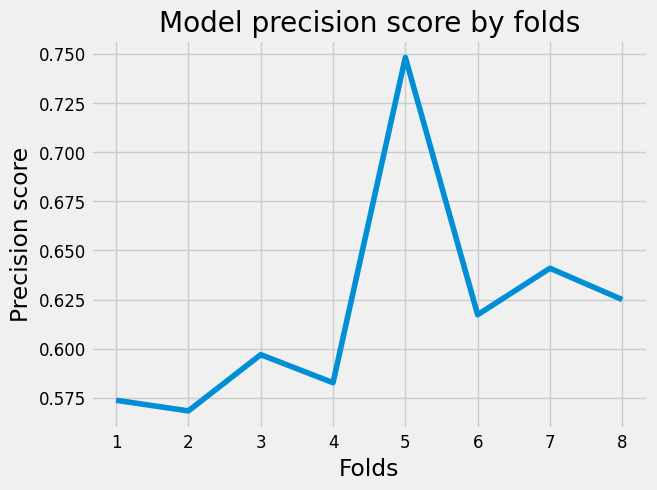

In [27]:
if not CFG.optimize and train_test == 'fold':
    sns.lineplot(x=list(range(1, 9)), y=prec_score_list)

    plt.title('Model precision score by folds')
    plt.xlabel('Folds')
    plt.xticks(fontsize=12)
    plt.ylabel('Precision score')
    plt.yticks(fontsize=12)

    plt.show()

### Distribution of model prediction scores

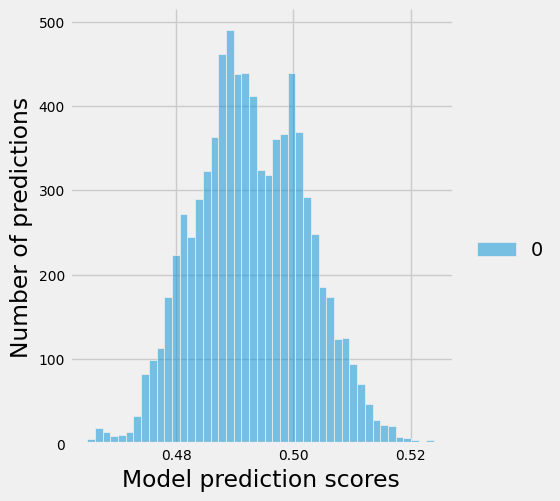

In [28]:
if not CFG.optimize and train_test == 'fold':
    sns.displot(oof)

    plt.xlabel('Model prediction scores')
    plt.xticks(fontsize=10)
    plt.ylabel('Number of predictions')
    plt.yticks(fontsize=10)

# Test model

### Test model predictions on the new data

In [29]:
if not CFG.optimize and train_test == 'full':
    model_lgb = joblib.load('model/lgbm.pkl')

    with open(f'model/bybit_tickers.json', 'r') as f:
        bybit_tickers = json.load(f)

    X = train_df[(train_df['ticker'].isin(bybit_tickers))]
    X['pred'] = model.predict_proba(X[features])[:,1]
    res = X.loc[(X['pred'] >= high_bound) & (X['time'] >= last_date), ['time', 'ticker', 'ttype', 'pred', 'target', 'pattern']]
    display(res['time'].min(), res['time'].max())
    display(res['target'].value_counts())
    display(res['target'].value_counts(normalize=True))

In [30]:
# Timestamp('2024-02-01 02:00:00')
# Timestamp('2024-03-11 16:00:00')

# 1    112
# 0     69

# Name: target, dtype: int641    0.618785
# 0    0.381215
# Name: target, dtype: float64

### Display PR curve

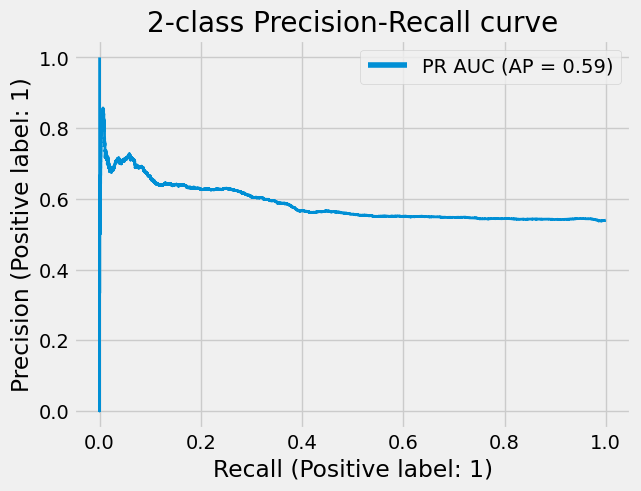

In [31]:
from sklearn.metrics import PrecisionRecallDisplay

if not CFG.optimize and train_test == 'fold':
    disp = PrecisionRecallDisplay.from_predictions(
        y.values, oof, name="PR AUC"
    )
    plt.legend(loc='upper right')
    _ = disp.ax_.set_title("2-class Precision-Recall curve")
    disp.ax_.lines[0].set_linewidth(2)

# vol 1e6 AP=0.61

### Find the best threshold

ic| bound: 0.3
    prec_score: 0.53945
    obj_num: 8162
    obj_pct: 1.0
    obj_profit: 644
ic| bound: 0.31
    prec_score: 0.53945
    obj_num: 8162
    obj_pct: 1.0
    obj_profit: 644
ic| bound: 0.32
    prec_score: 0.53945
    obj_num: 8162
    obj_pct: 1.0
    obj_profit: 644
ic| bound: 0.33
    prec_score: 0.53945
    obj_num: 8162
    obj_pct: 1.0
    obj_profit: 644
ic| bound: 0.34
    prec_score: 0.53945
    obj_num: 8162
    obj_pct: 1.0
    obj_profit: 644
ic| bound: 0.35
    prec_score: 0.53945
    obj_num: 8162
    obj_pct: 1.0
    obj_profit: 644
ic| bound: 0.36
    prec_score: 0.53945
    obj_num: 8162
    obj_pct: 1.0
    obj_profit: 644
ic| bound: 0.37
    prec_score: 0.53945
    obj_num: 8162
    obj_pct: 1.0
    obj_profit: 644
ic| bound: 0.38
    prec_score: 0.53945
    obj_num: 8162
    obj_pct: 1.0
    obj_profit: 644
ic| bound: 0.39
    prec_score: 0.53945
    obj_num: 8162
    obj_pct: 1.0
    obj_profit: 644
ic| bound: 0.4
    prec_score: 0.53945
    obj_num:

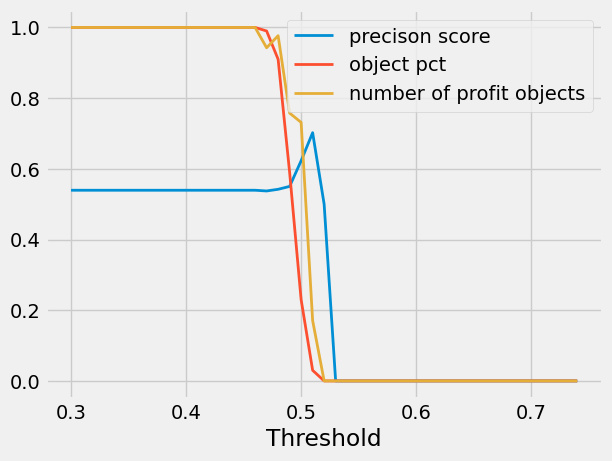

In [32]:
from icecream import ic

if not CFG.optimize and train_test == 'fold':
    prec_score_list = list()
    obj_num_list = list()
    obj_pct_list = list()
    obj_profit_list = list()
    max_obj_profit = 0
    for hb in np.arange(0.3, 0.75, 0.01):
        prec_score, obj_num, obj_pct = confident_score(y.reset_index(drop=True), oof, 1-hb, hb)
        if prec_score == 0:
            obj_num = 0
            obj_pct = 0
        bound, prec_score, obj_num, obj_pct = round(hb, 2), round(prec_score, 5), round(obj_num, 2), round(obj_pct, 2)
        obj_profit = round((2 * prec_score - 1) * obj_num)
        prec_score_list.append(prec_score)
        obj_num_list.append(obj_num)
        obj_pct_list.append(obj_pct)
        obj_profit_list.append(obj_profit)
        max_obj_profit = max(max_obj_profit, obj_profit)
        ic(bound, prec_score, obj_num, obj_pct, obj_profit)

    obj_profit_list = [o / max_obj_profit for o in obj_profit_list]
    line1 = plt.plot(np.arange(0.3, 0.75, 0.01), prec_score_list, label='precison score', linewidth=2)
    line2 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_pct_list, label='object pct', linewidth=2)
    line3 = plt.plot(np.arange(0.3, 0.75, 0.01), obj_profit_list, label='number of profit objects', linewidth=2)
    plt.legend()
    plt.xlabel("Threshold")
    plt.show()

# Compare indicator / signal values for bot and optimizer

In [33]:
# import pandas as pd
# from signals.find_signal import SignalFactory

# ttype = 'buy'
# ticker = 'METHUSDT'
# month = 1
# day = 25
# hour = 6
# configs = ConfigFactory.factory(environ).configs

# x = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_1h_{ttype}_{month}_{day}_{hour}.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)
# y = pd.read_csv(f'../bot/ticker_dataframes/{ticker}_4h_{ttype}_{month}_{day}_3.csv').drop(columns=['Unnamed: 0']).reset_index(drop=True)

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# x = vol24.get_indicator(x, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# x = pattern.get_indicator(x, '', '', 0)
# # add trend
# trend = indicators.Trend(ttype, configs)
# y = trend.get_indicator(y, '', '', 0)

# # cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'rsi', 'stoch_slowk', 'stoch_slowd', 'linear_reg', 'linear_reg_angle', 'macd', 'macdsignal', 'macdhist']
# cols = ['time', 'open', 'high', 'low', 'close', 'volume', 'linear_reg', 'linear_reg_angle', 'high_max', 'low_min', 'volume_24']

# higher_features = ['time_4h', 'linear_reg', 'linear_reg_angle', 'macd', 'macdhist',  'macd_dir', 
#                    'macdsignal', 'macdsignal_dir']
# y['time_4h'] = y['time'] + pd.to_timedelta(3, unit='h')
# x[['time'] + higher_features] = pd.merge(x[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# x.drop(columns=['time_4h'], inplace=True)
# y.drop(columns=['time_4h'], inplace=True)
# x.ffill(inplace=True)
# x.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(x)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(x)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(x.loc[idxs[0], cols])

# z = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_1h.pkl')
# v = pd.read_pickle(f'../optimizer/ticker_dataframes/{ticker}_4h.pkl')

# # add Volume24
# vol24 = indicators.Volume24(ttype, configs)
# z = vol24.get_indicator(z, '', '1h', 0)
# # add Pattern
# pattern = indicators.Pattern(ttype, configs)
# z = pattern.get_indicator(z, '', '', 0)
# # add Trend
# trend = indicators.Trend(ttype, configs)
# v = trend.get_indicator(v, '', '', 0)
# z.tail(48)

# v['time_4h'] = v['time'] + pd.to_timedelta(3, unit='h')
# z[['time'] + higher_features] = pd.merge(z[['time']], y[higher_features], how='left', left_on='time', right_on='time_4h')

# z.drop(columns=['time_4h'], inplace=True)
# v.drop(columns=['time_4h'], inplace=True)
# z.ffill(inplace=True)
# z.reset_index(drop=True, inplace=True)

# # get Swing pattern
# pattern = SignalFactory().factory('Pattern', ttype, configs)
# pattern_points = pattern.find_signal(z)
# trend = SignalFactory().factory('Trend', ttype, configs)
# trend_points = trend.find_signal(z)
# idxs = np.where((pattern_points > 0) & (trend_points > 0))
# display(z.loc[idxs[0], cols][-1:])